<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/Cw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import copy
import tqdm
import itertools
import seaborn as sns
import os
import pickle
import scipy.signal as ss


sns.set()
sns.set_context("talk", font_scale=1.4)

!pip install obci_readmanager
from obci_readmanager.signal_processing.read_manager import ReadManager

    100% |████████████████████████████████| 61kB 4.0MB/s 
    100% |████████████████████████████████| 6.2MB 5.6MB/s 
  Running setup.py bdist_wheel for mne ... - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


## Filtry

---


In [0]:
from scipy.signal import butter, filtfilt, iirnotch, freqz, lfilter, cheby2


def _butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = _butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def _butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = _butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def notch_filter(data, f0, fs, Q=30):
    nyq = 0.5 * fs
    w0 = f0/nyq
    b, a = iirnotch(w0, Q)
    y = filtfilt(b, a, data)
    return y
  
  
def _cheb2_notch(cutoff, fs, order=5, rs=3, width=.1):
    nq = fs/2
    Wn_min, Wn_max = (cutoff - width) / nq, (cutoff + width) / nq
    Wn = [Wn_min, Wn_max]
    b, a = cheby2(N=order, rs=rs, Wn=Wn, btype='bandstop', analog=False, output='ba')
    return b, a

# Analiza Sygnału

##Wersja 1.1: Obserwacja jednej błyskającej diody

### Read Data

#### Reading signals


In [0]:
filename = "labeeg_1.tar.gz"
site = 'http://studenci.fuw.edu.pl/~cp383253/cw3/'
files = site + filename
os.system(f'wget {files}')
os.system(f'tar -xvzf {filename}')

0

In [0]:
filename = "ssvep_1"
extentions = ['.xml', '.raw', '.tag']

mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)
fs = int(float(mgr.get_param("sampling_frequency")))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

raw_syg = mgr.get_microvolt_samples()
t = np.arange(raw_syg.shape[1])/fs
print('channels :', channels_names)

2019-01-21 13:34:59,314 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


channels : ['O1', 'O2', 'P7', 'P3', 'Pz', 'P4', 'P8', 'TP9', 'TP10', 'T7', 'C3', 'Cz', 'C4', 'T8', 'FCz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'AFz', 'Fp1', 'Fp2', 'd1', 'd2', 'Saw']


#### Montage

In [0]:
montage_syg = np.copy(raw_syg)
montage_syg[:-3,:] -= (raw_syg[channels_names.index('TP9'),:] + raw_syg[channels_names.index('TP10'),:])/2

### Filtering

#### Define filter

In [0]:
def filter_data(data, fs):
  '''
  Filtering 0.1 - 20 Hz
  '''
  data = butter_lowpass_filter(data, 45, fs, order=2)

  data = butter_highpass_filter(data, 1, fs, order=5)

  data = notch_filter(data, 50, fs)

  return data

In [0]:
syg = np.copy(montage_syg)
t = np.copy(t)

for channel in channels_names[:-3]:
  print('Filtering:', channel)
  index = channels_names.index(channel)
  syg[index,:] = filter_data(syg[index,:], fs)

Filtering: O1
Filtering: O2
Filtering: P7
Filtering: P3
Filtering: Pz
Filtering: P4
Filtering: P8
Filtering: TP9
Filtering: TP10
Filtering: T7
Filtering: C3
Filtering: Cz
Filtering: C4
Filtering: T8
Filtering: FCz
Filtering: F7
Filtering: F3
Filtering: Fz
Filtering: F4
Filtering: F8
Filtering: AFz
Filtering: Fp1
Filtering: Fp2


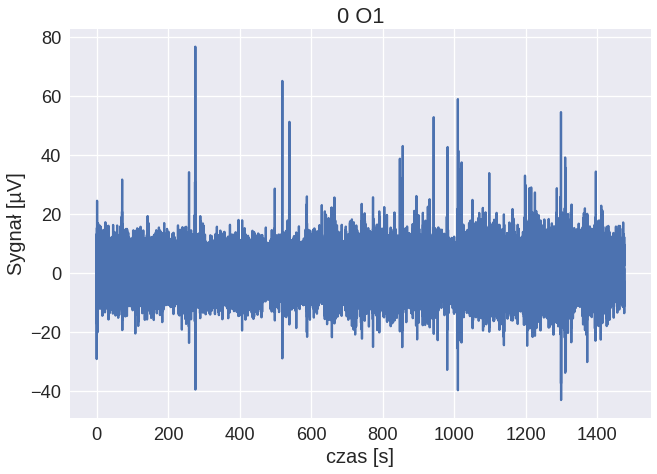

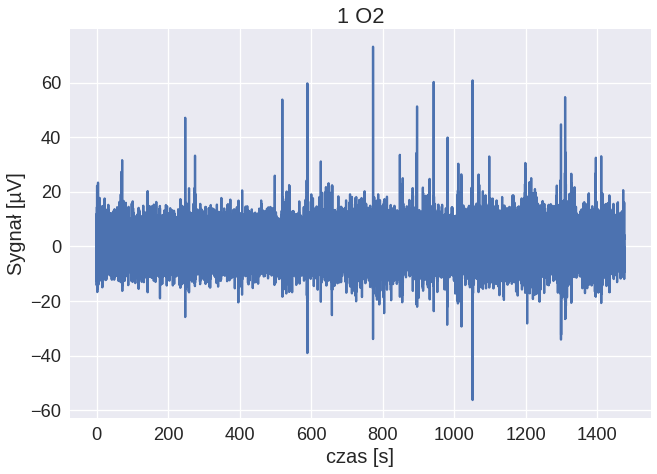

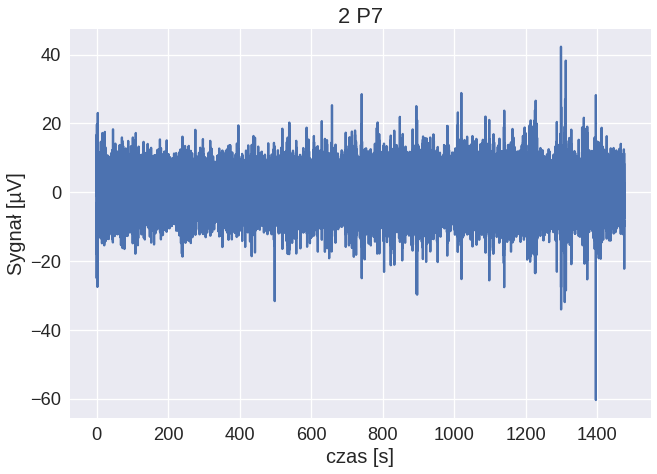

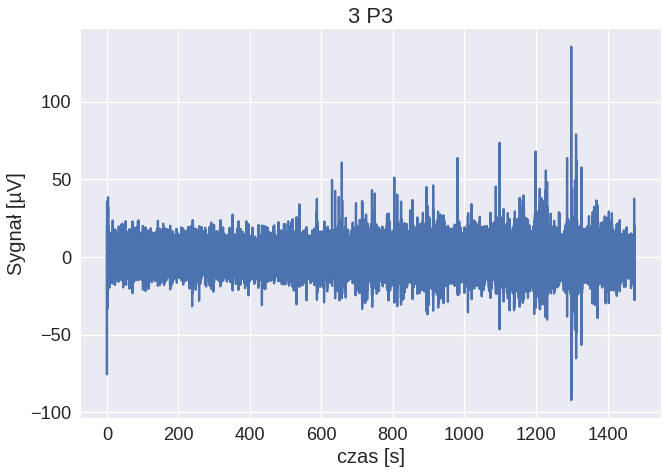

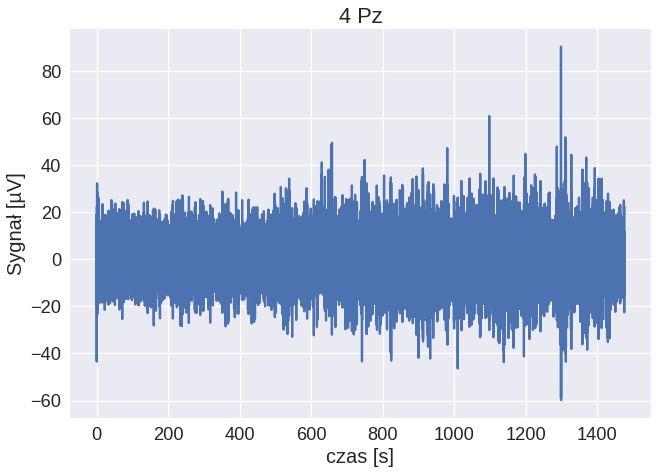

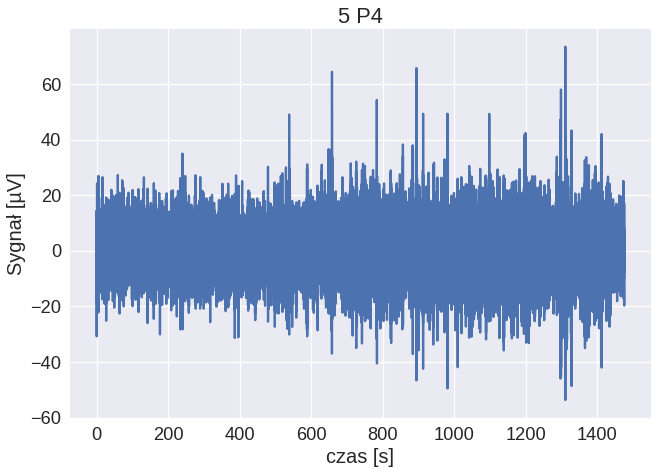

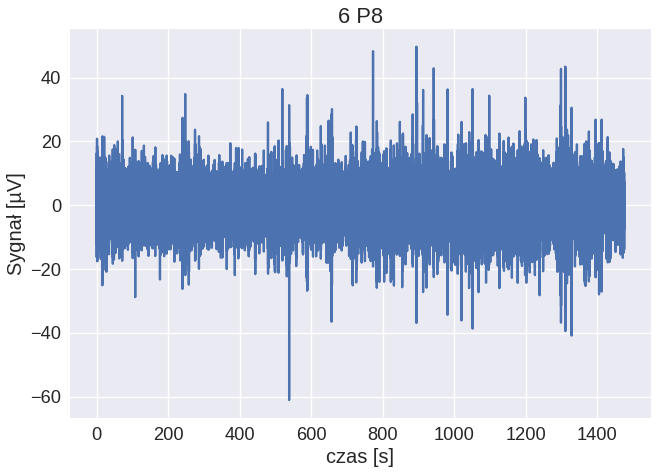

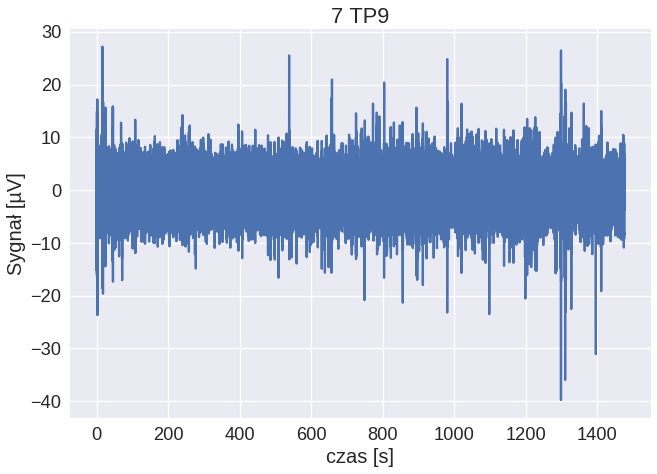

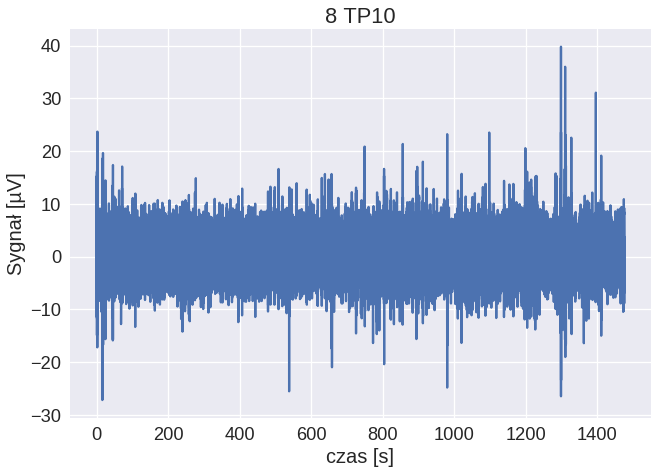

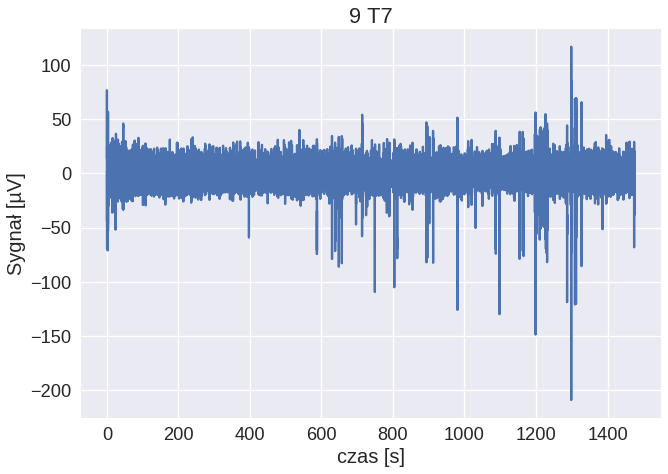

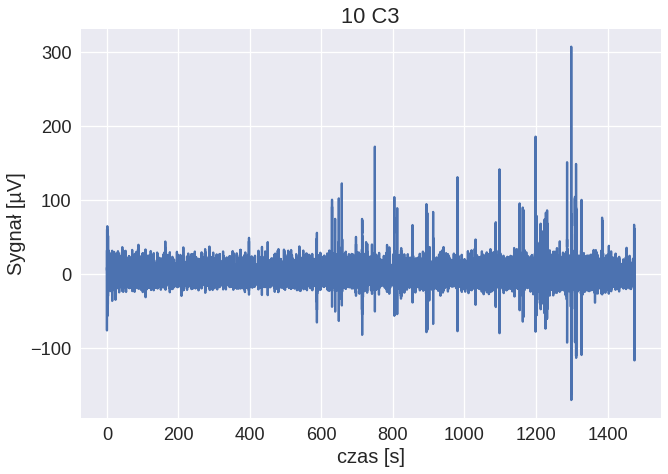

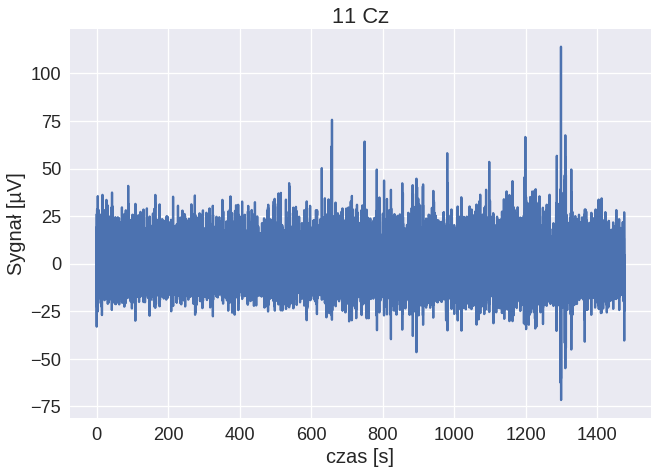

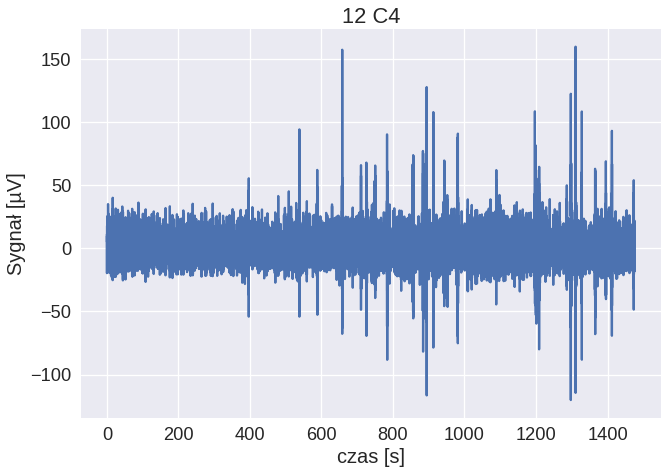

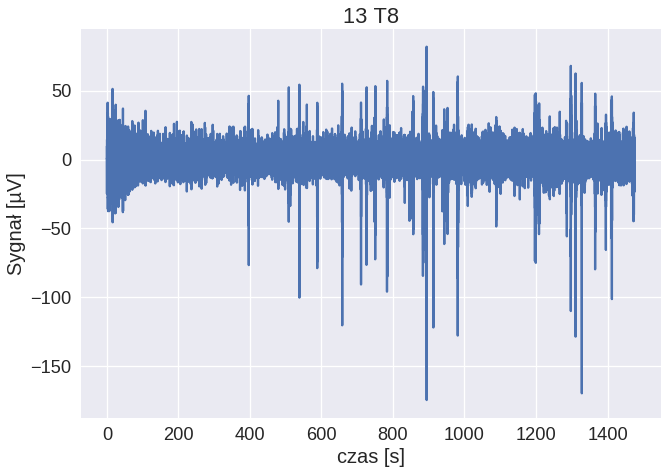

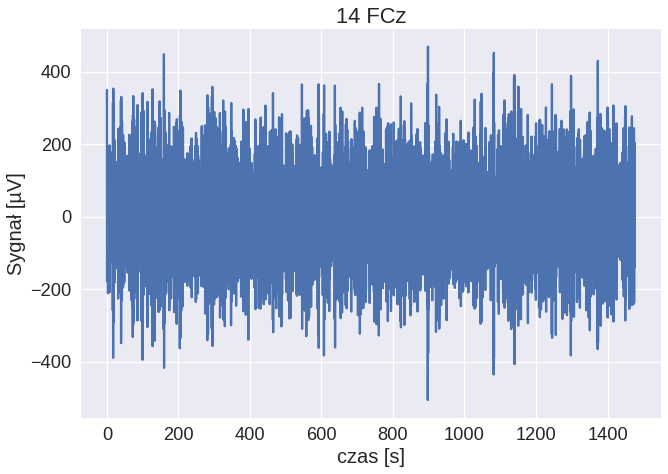

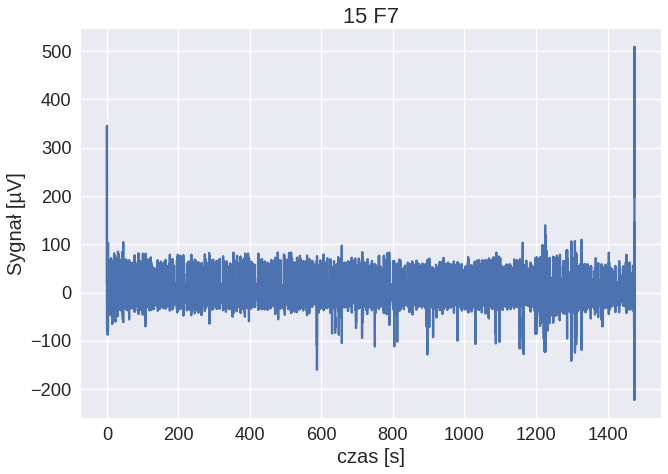

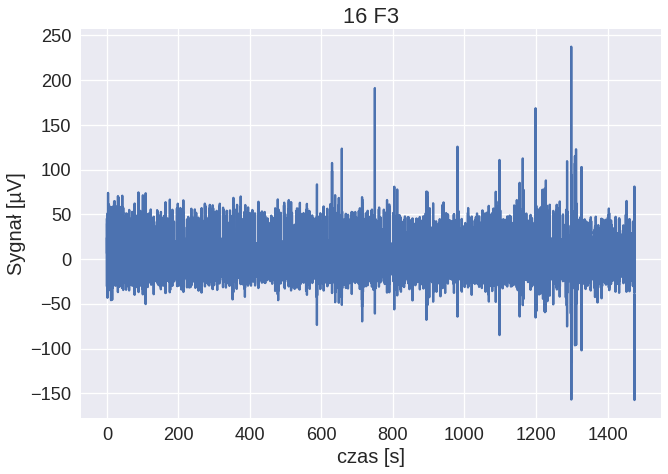

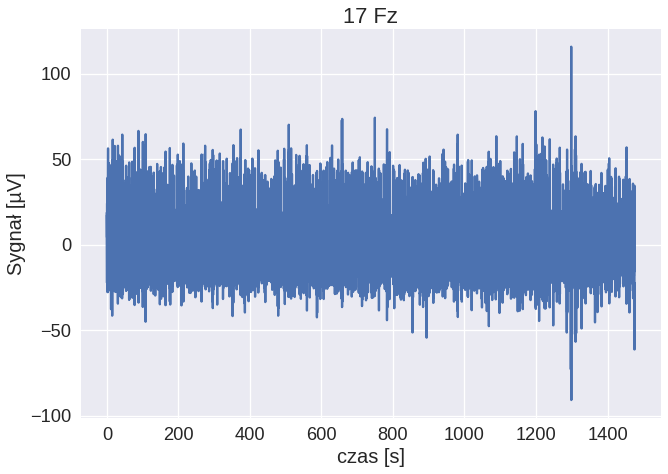

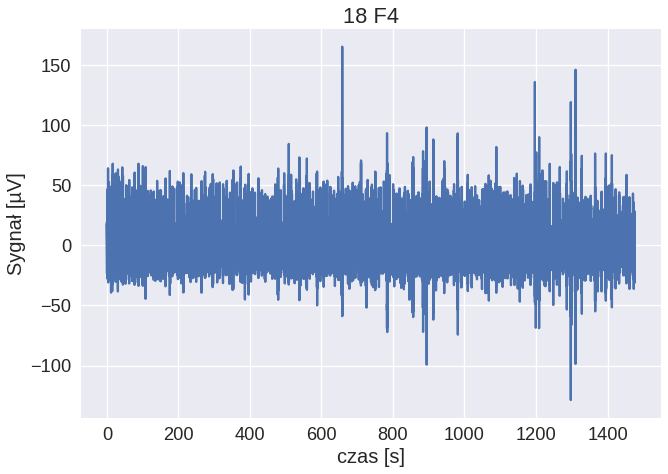

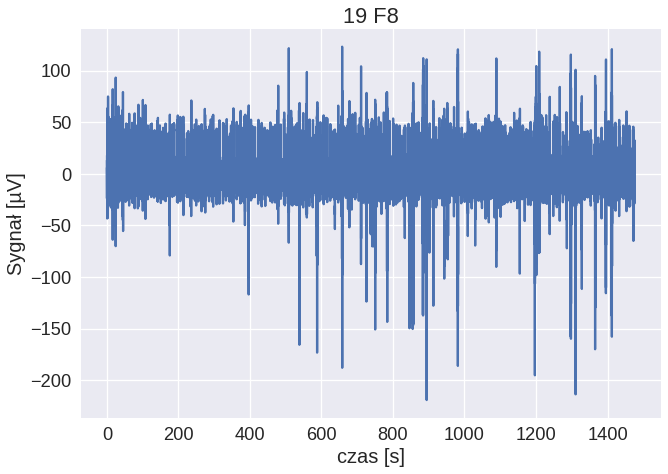

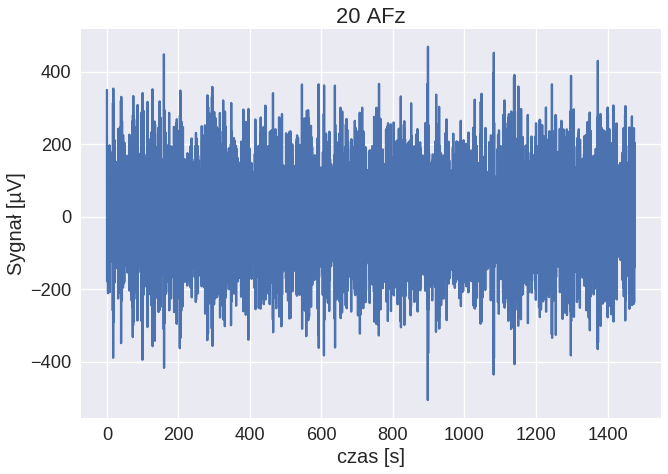

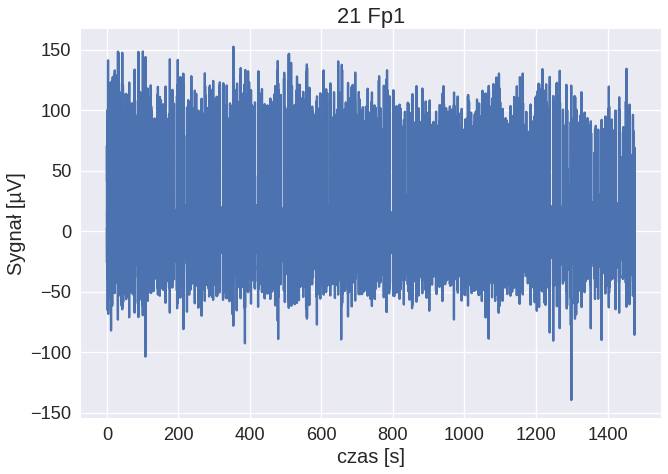

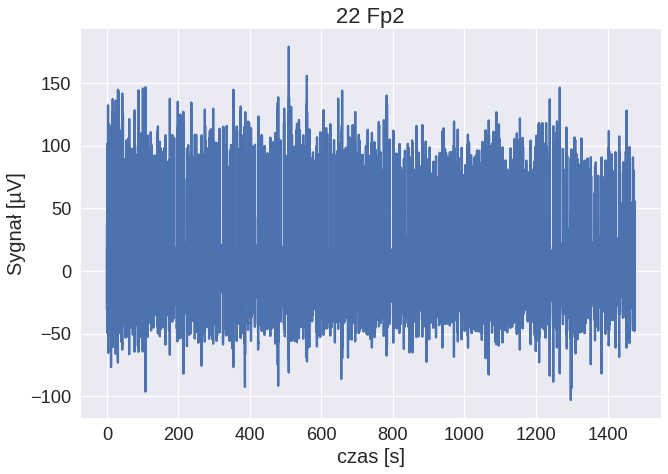

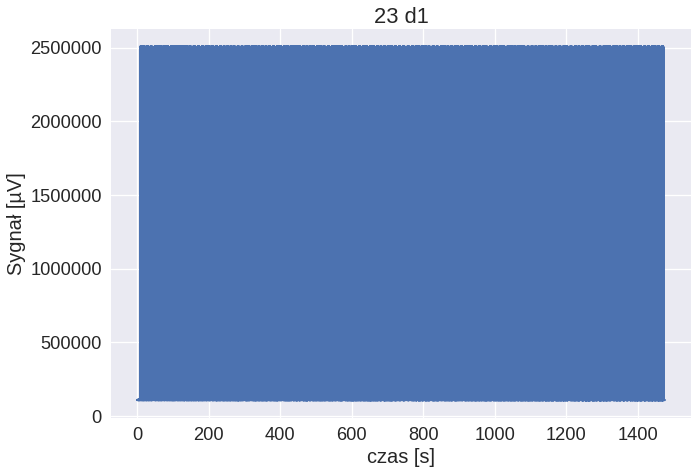

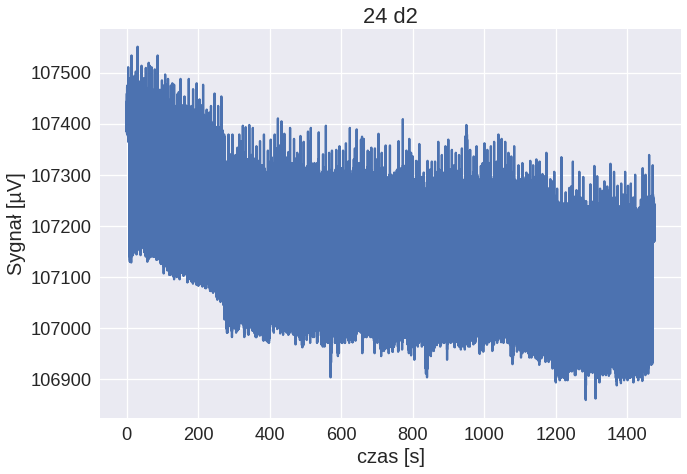

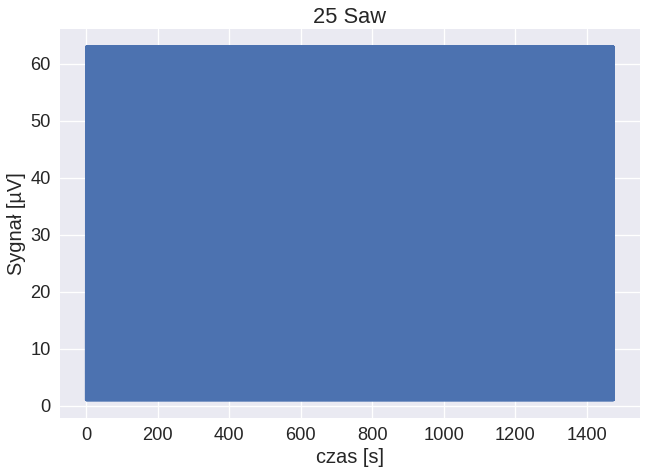

In [0]:
for i, channel in enumerate(channels_names):
  
  start_time = 0
  end_time = syg.shape[1]
  
  plt.plot(
      t[start_time * fs:end_time * fs],
      syg[i, start_time * fs:end_time * fs]
  )
  plt.title(f'{i} {channel}')
  plt.xlabel('czas [s]')
  plt.ylabel('Sygnał [µV]')
  plt.show()

#### Selecting channels

In [0]:
old_channels_names = channels_names[:]
channels_names = ['Fp1', 'Fp2', 'Cz', 'P3', 'Pz', 'P4', 'O1', 'O2', 'P7', 'P8', 'd1']

selected_syg = []

for channel in channels_names:
  selected_syg.append(syg[old_channels_names.index(channel),:])
  
syg = np.array(selected_syg)




#### Display Filtered Data

(1510848,)


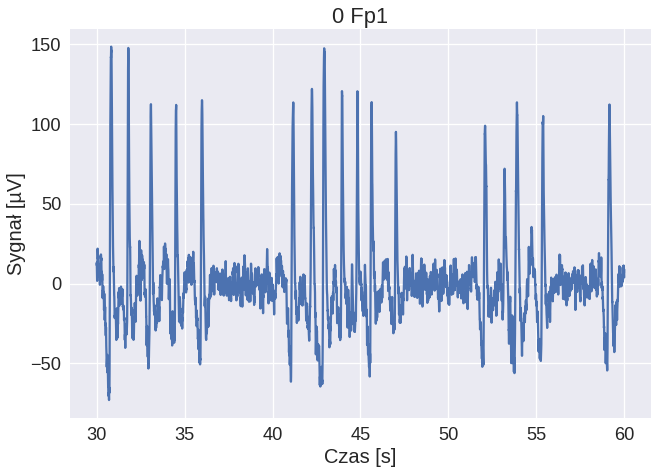

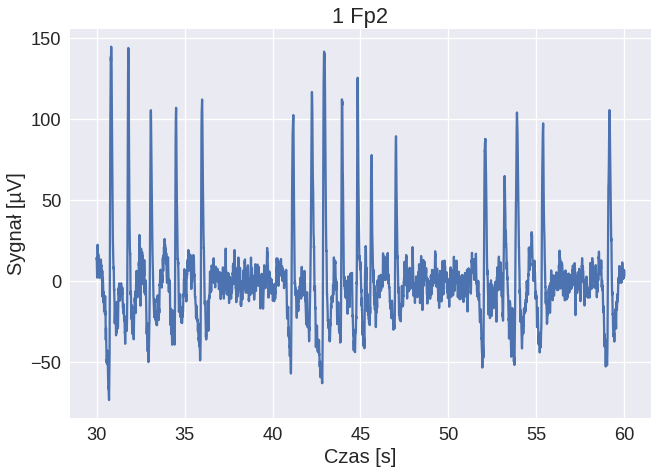

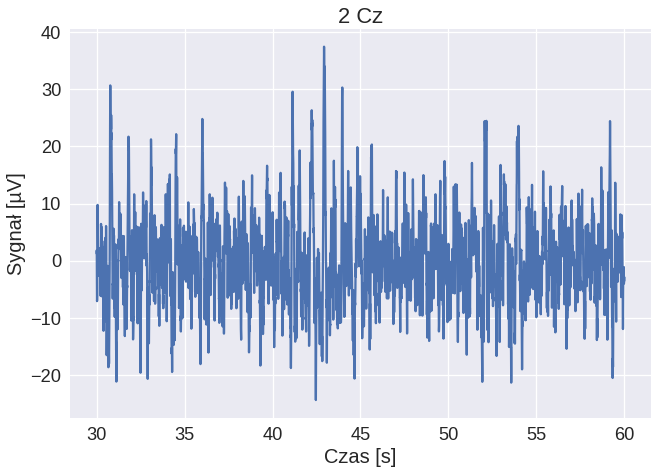

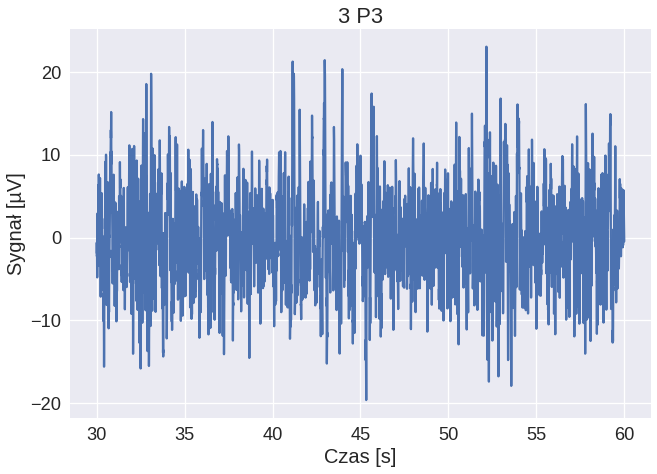

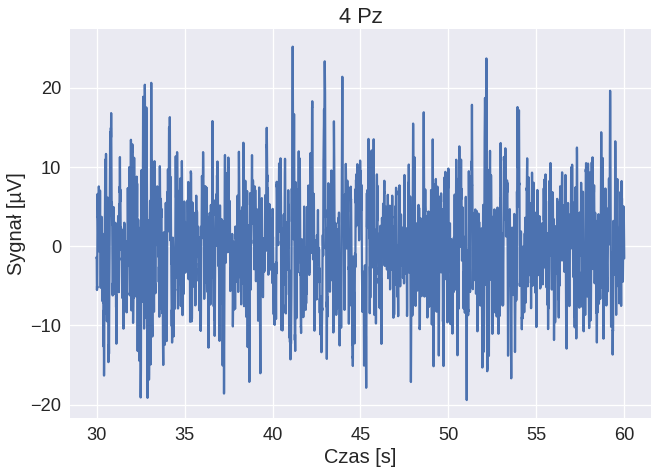

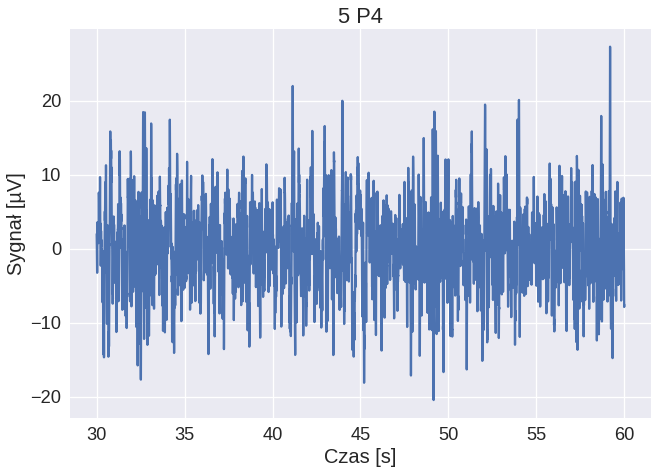

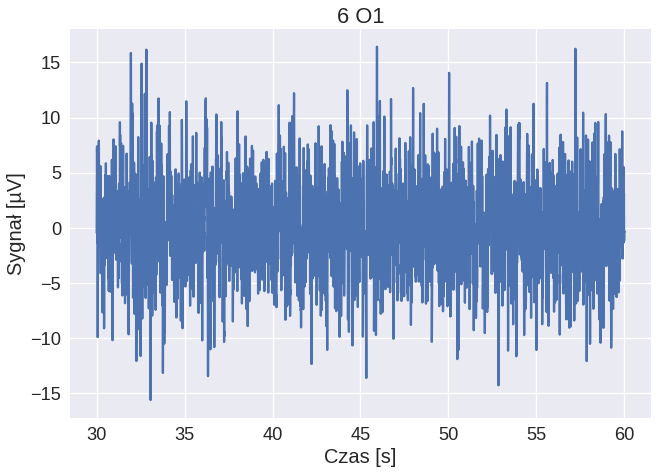

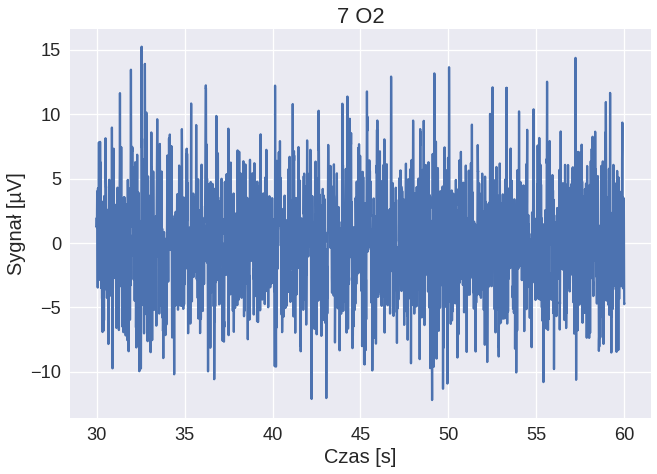

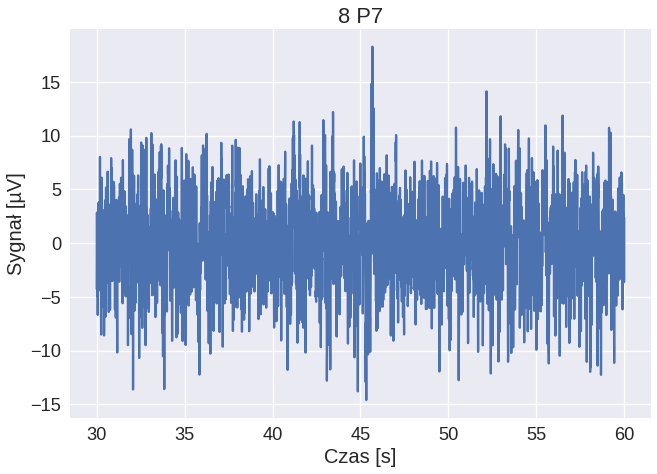

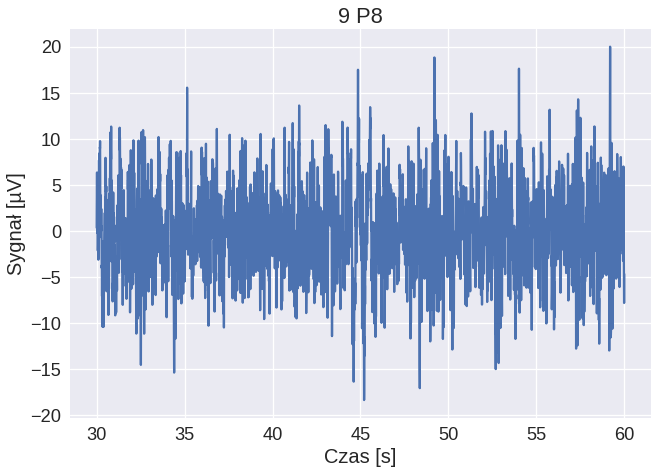

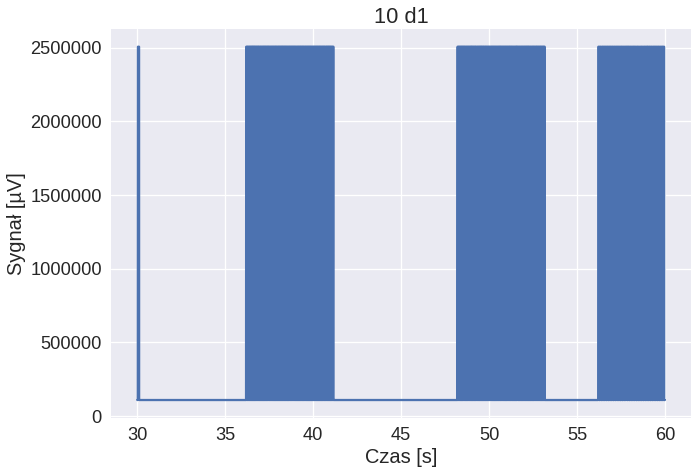

In [0]:
print(t.shape)
for i, channel in enumerate(channels_names):
  
  start_time = 30
  end_time = 60 #syg.shape[1]
  
  plt.plot(
      t[start_time * fs:end_time * fs],
      syg[i, start_time * fs:end_time * fs]
  )
  plt.title(f'{i} {channel}')
  plt.xlabel('Czas [s]')
  plt.ylabel('Sygnał [µV]')
  plt.show()

### Extract Frequencies and Start tags

## I sposób

In [0]:
def get_group_tags(signals, channel_names, fs, smallest_frequency=4, trial_length=5):
    '''
    :param signals:
    :param channel_names:
    :param fs:
    :param smallest_frequency: default value of frequency from:
        https://brain.fuw.edu.pl/edu/index.php/Pracownia_EEG/SSVEP_1#Przygotowanie_programu_do_sterowania_eksperymentem
    :param trial_length: length of the trial in seconds. Default from:
        https://brain.fuw.edu.pl/edu/index.php/Pracownia_EEG/SSVEP_1
    :return:
    '''

    def extract_diode(): return np.copy(signals[channel_names.index('d1')])

    def extract_blink_tags(signal):
        positions_above_threshold = [i for i, sig in enumerate(signal) if sig > 0.9]

        end_of_diode = [i + 1 for i, index in enumerate(np.diff(positions_above_threshold)) if index > 1]

        end_of_diode = [0] + end_of_diode

        return list(map(lambda x: positions_above_threshold[x], end_of_diode))

    def extract_trial_tags(tags):
        max_difference = int(1 / smallest_frequency * fs) + 1

        start = [i + 1 for i, tag in enumerate(np.diff(tags)) if tag > max_difference]
        start = [0] + start

        return list(map(lambda x: tags[x], start))

    def group_by_frequency(ttags, btags, length, fs):
        groups = {}
        for tag in ttags:
            start = tag
            end = int(start + length * fs)

            blinks = len(list(filter(lambda x: start < x < end, btags)))

            frequency = int(blinks // length) + 1

            if frequency in groups.keys():
                groups[frequency].append((start, end))
            else:
                groups[frequency] = [(start, end)]

        return groups

    diode_signal = extract_diode()
    diode_signal /= np.max(diode_signal)

    blink_tags = extract_blink_tags(diode_signal)

    trial_tags = extract_trial_tags(blink_tags)

    return group_by_frequency(trial_tags, blink_tags, trial_length, fs)

In [0]:

def get_safe_frequencies(freqs, freq):
    for f in freqs:
        is_harmonic = not bool(freq % f)
        is_sub_harmonic = not bool(f % freq)
        if not is_harmonic and not is_sub_harmonic:
            yield f


def get_SSVEP_score_with_trust(channel_signal, groups, SSVEP_score_func, calc_scores_func):
  score_with_trust = []

  def get_SSVEP_trust_interval(frequency_idx, trials):
    '''
    Uses bootstrap with replacement
    '''
    scores = []
    for _ in range(1000):
      new_trials = np.random.randint(0, len(trials), len(trials))

      bootstrapped_trials = np.array(trials)[new_trials]

      F = calc_scores_func(bootstrapped_trials)

      scores.append(F[frequency_idx])

    return [st.scoreatpercentile(scores, 2.5),
  st.scoreatpercentile(scores, 97.5)]

  for frequency in groups.keys():
    prim_score, frequency_idx, trials = SSVEP_score_func(channel_signal, frequency)

    score_trust = get_SSVEP_trust_interval(frequency_idx, trials)

    score_with_trust.append((prim_score, score_trust))

  return score_with_trust


def get_background_trust(channel_signal, groups, SSVEP_score_func):
    background_trust = []
    for frequency in groups.keys():
        freqs = list(get_safe_frequencies(groups.keys(), frequency))

        background_SSVEP_scores = []

        for _ in range(1000):
            new_freqs = np.random.choice(freqs)

            SSVEP_score, _, _ = SSVEP_score_func(channel_signal, new_freqs, at_freq=frequency)

            background_SSVEP_scores.append(SSVEP_score)

        background_trust.append([st.scoreatpercentile(background_SSVEP_scores, 2.5), st.scoreatpercentile(background_SSVEP_scores, 97.5)])
    return background_trust
  
def method(signals, channel_names, groups: dict, FS, calc_scores_func):
  def get_SSVEP_score(channel_signal, frequency, at_freq=None):
      if not at_freq: at_freq = frequency

      trials = np.array([channel_signal[start:end] for start, end in groups[frequency]])

      F = calc_scores_func(trials)

      freqs = np.fft.fftfreq(len(F), 1 / 1024)

      frequency_idx = (np.abs(freqs - at_freq)).argmin()

      return F[frequency_idx], frequency_idx, trials

  for channel_name in channel_names[:-1][::-1]:
      ch_signal = signals[channel_names.index(channel_name)]

      score = get_SSVEP_score_with_trust(ch_signal, groups, get_SSVEP_score, calc_scores_func)

      score0 = list(map(lambda x: x[0], score))
      trust_low = list(map(lambda x: x[1][0], score))
      trust_high = list(map(lambda x: x[1][1], score))

      background = get_background_trust(ch_signal, groups, get_SSVEP_score)
      background_low = list(map(lambda x: x[0], background))
      background_high = list(map(lambda x: x[1], background))

      fs = list(groups.keys())

      fs, background, background_low, background_high, score0, trust_low, trust_high = zip(*sorted(zip(fs, background, background_low, background_high, score0, trust_low, trust_high)))
      
      yield (fs, background, background_low, background_high, score0, trust_low, trust_high, channel_name)

def plot_ssvep_curve(fs, background, background_low, background_high, score0, trust_low, trust_high, channel_name, cs, name):
  plt.fill_between(fs, trust_low, trust_high, color=cs[0], alpha=0.1, label='Przedział Ufności SSVEP {}'.format(name))
  plt.fill_between(fs, background_low, background_high, color=cs[1], alpha=0.2, label='Przedział Ufności Tła {}'.format(name))

  plt.plot(fs, score0, c=cs[2], linewidth=3.0, label='Wartość SSVEP {}'.format(name))

  plt.xlabel('Częstotliwość [Hz]')
  plt.ylabel('Wartość SSVEP')
  plt.title('Zależność SSVEP od częśtotliwości dla kanału %s'%channel_name)
  plt.xlim(0,None)
  plt.ylim(1,None)
  plt.yscale('log')

In [0]:
'''
Sposób II:
 - Uśrednij sygnały odpowiadające stymulacji tą samą częstością.
 - Obejrzyj uśrednione sygnały. (Zaprezentuj je).
 - Wyestymuj przy pomocy transformaty Fouriera widmo amplitudowe
średniego sygnału EEG.
 - Dla każdej częstości stymulacji wyznacz miarę odpowiedzi SSVEP wraz
z 95% przedziałem ufności dla średniej. Dla każdej częstości
stymulacji wyznacz także poziom tła.
 - Sporządź wykres odpowiedzi SSVEP od częstości. Znajdź częstości,
dla których odpowiedź ta była najsilniejsza
'''

'\nSposób II:\n - Uśrednij sygnały odpowiadające stymulacji tą samą częstością.\n - Obejrzyj uśrednione sygnały. (Zaprezentuj je).\n - Wyestymuj przy pomocy transformaty Fouriera widmo amplitudowe\nśredniego sygnału EEG.\n - Dla każdej częstości stymulacji wyznacz miarę odpowiedzi SSVEP wraz\nz 95% przedziałem ufności dla średniej. Dla każdej częstości\nstymulacji wyznacz także poziom tła.\n - Sporządź wykres odpowiedzi SSVEP od częstości. Znajdź częstości,\ndla których odpowiedź ta była najsilniejsza\n'

In [0]:
'''
Sposób II:
Uśrednij sygnały odpowiadające stymulacji tą samą częstością.
Obejrzyj uśrednione sygnały. (Zaprezentuj je).
Wyestymuj przy pomocy transformaty Fouriera widmo amplitudowe średniego sygnału EEG.
Dla każdej częstości stymulacji wyznacz miarę odpowiedzi SSVEP wraz z 95% przedziałem ufności dla średniej. Dla każdej częstości stymulacji wyznacz także poziom tła.
Sporządź wykres odpowiedzi SSVEP od częstości. Znajdź częstości, dla których odpowiedź ta była najsilniejsza.

Sposób III:
Dla każdego powtórzenia o danej częstości oblicz transformatę Fouriera
Uśrednij zespolone transformaty
Wyestymuj widmo amplitudowe z uśrednionej transformaty Fouriera (oblicz jej moduł), wraz z 95% przedziałem ufności dla średniej. Dla każdej częstości stymulacji wyznacz także poziom tła.
Sporządź wykres odpowiedzi SSVEP od częstości. Znajdź częstości, dla których odpowiedź ta była najsilniejsza.
'''
def method_1(trials):
  _Fs = [np.abs(np.fft.fft(trail)) ** 2 for trail in trials]
  _F = np.mean(_Fs, axis=0)
  return _F

def method_2(trials):
  m = np.mean(trials, axis=0)
  S = np.fft.fft(m)
  return np.abs(S)**2
  
def method_3(trials):
  SS = np.array([np.fft.fft(trial) for trial in trials])
  F = np.mean(SS, axis=0)
  return np.abs(F)**2


In [0]:
_syg = np.copy(syg)
tags = get_group_tags(_syg, channels_names, fs)
print(tags)

{40: [(8350, 13470), (148797, 153917), (274885, 280005), (297436, 302556), (327165, 332285), (376370, 381490), (418396, 423516), (513728, 518848), (544483, 549603), (564985, 570105), (594715, 599835), (633671, 638791), (868426, 873546), (886875, 891995), (988365, 993485)], 25: [(16552, 21672), (223630, 228750), (286161, 291281), (1167765, 1172885), (1262079, 1267199), (1282582, 1287702), (1290783, 1295903), (1302060, 1307180), (1322560, 1327680), (1450703, 1455823), (1472231, 1477351), (1480433, 1485553), (1490684, 1495804), (1500936, 1506056)], 7: [(25778, 30898), (104715, 109835), (139571, 144691), (160072, 165192), (203127, 208247), (213378, 218498), (366119, 371239), (437870, 442990), (521929, 527049), (653148, 658268), (715682, 720802), (814094, 819214), (844848, 849968), (946334, 951454), (966837, 971957)], 16: [(37055, 42175), (49357, 54477), (65759, 70879), (355867, 360987), (673651, 678771), (705431, 710551), (856125, 861245), (954535, 959655), (1019120, 1024240), (1087805, 10

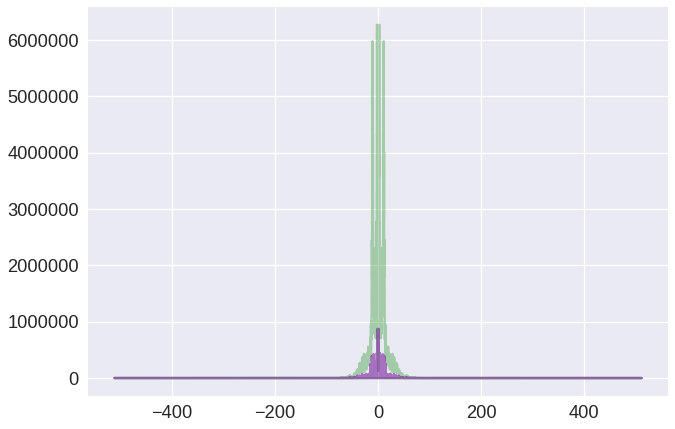

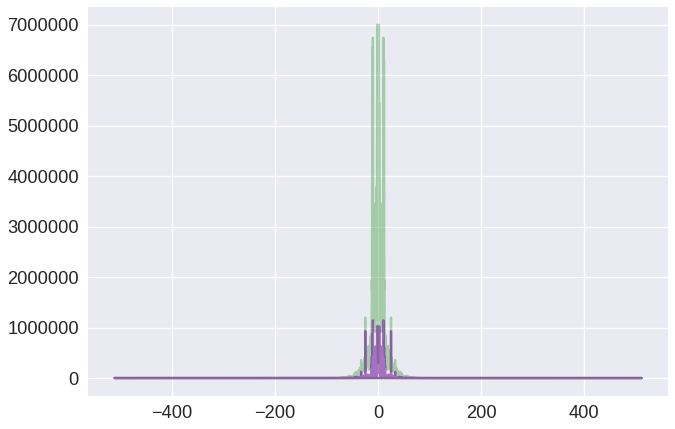

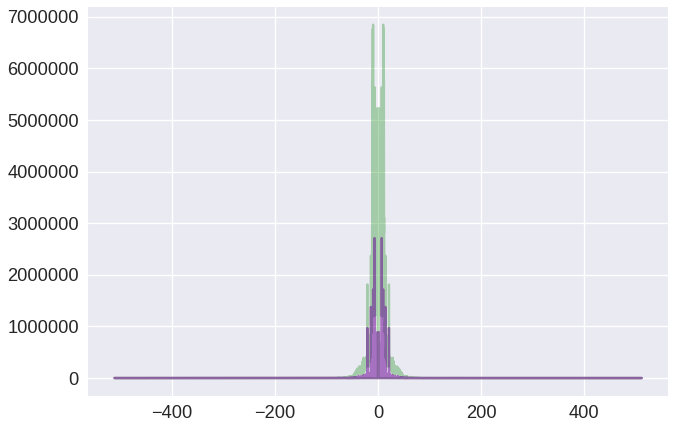

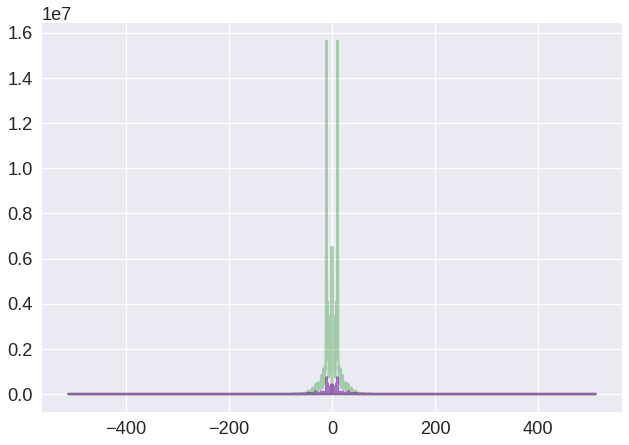

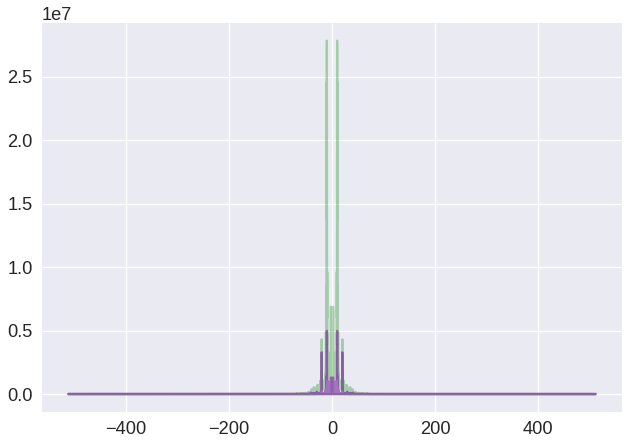

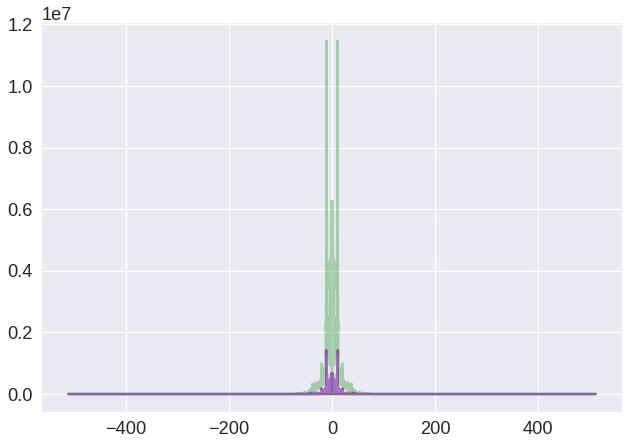

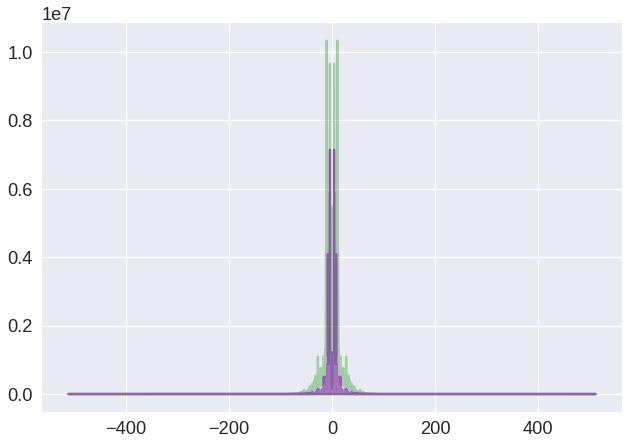

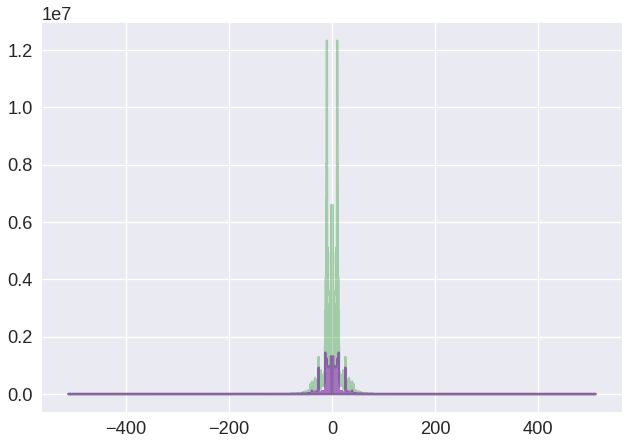

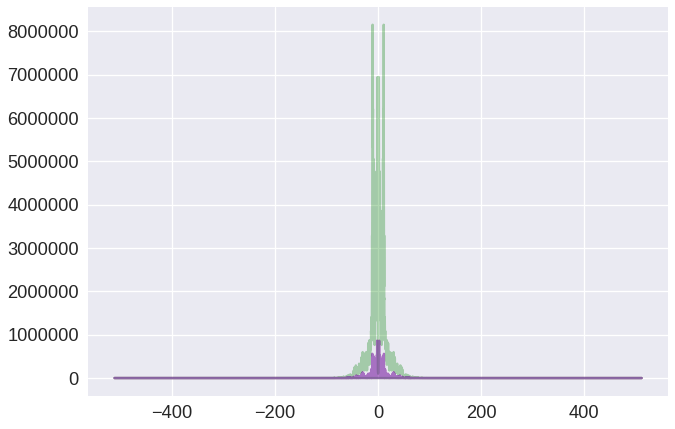

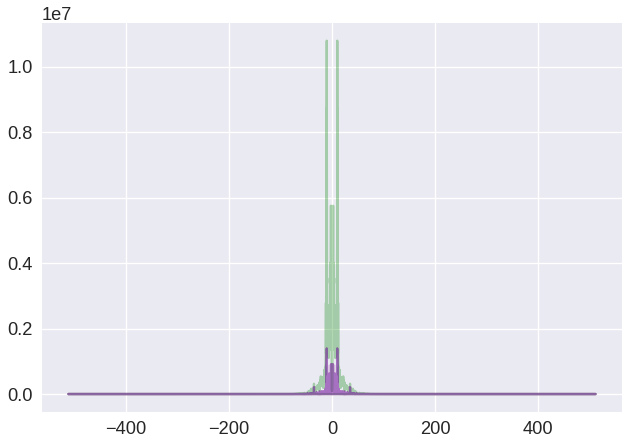

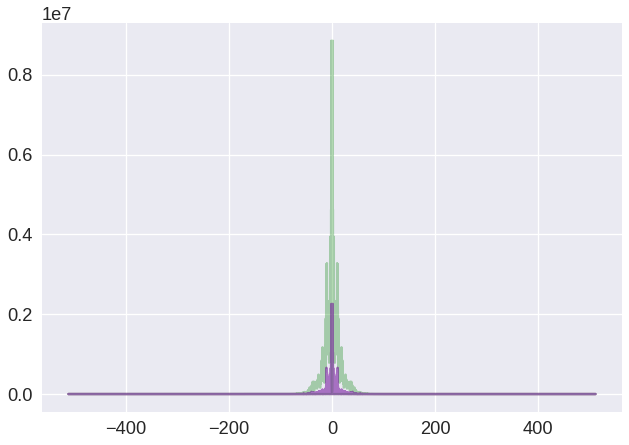

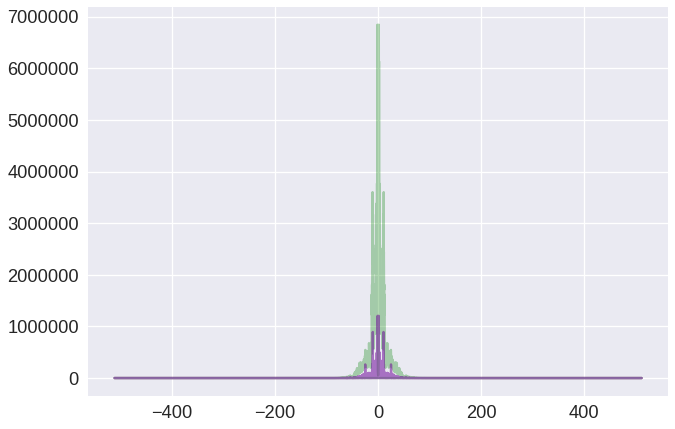

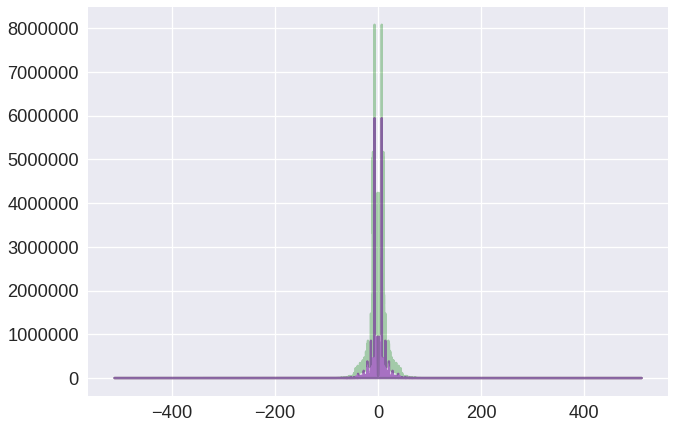

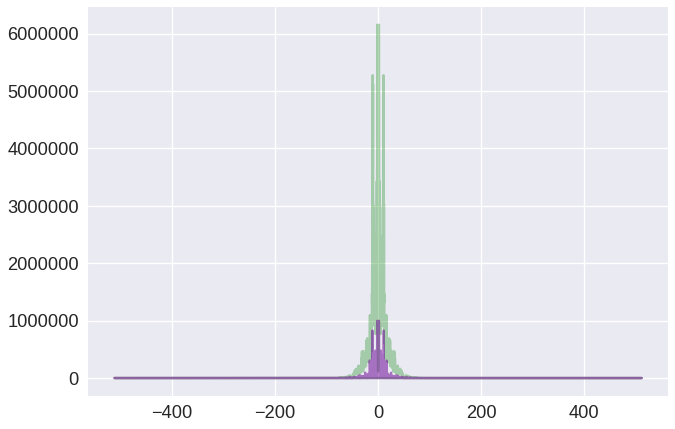

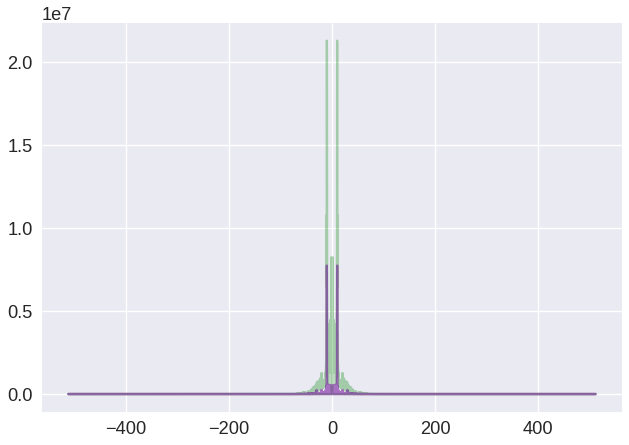

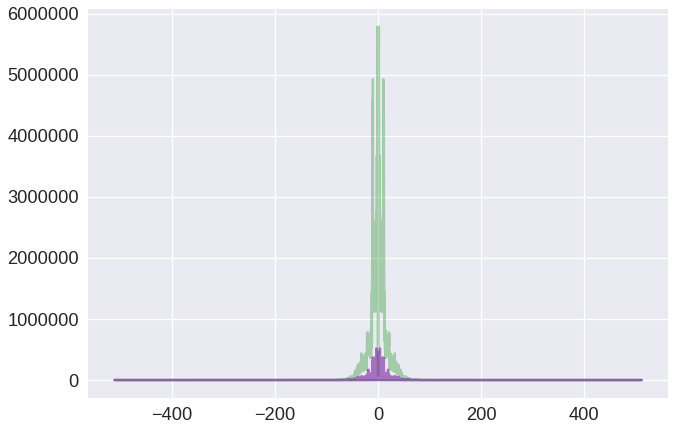

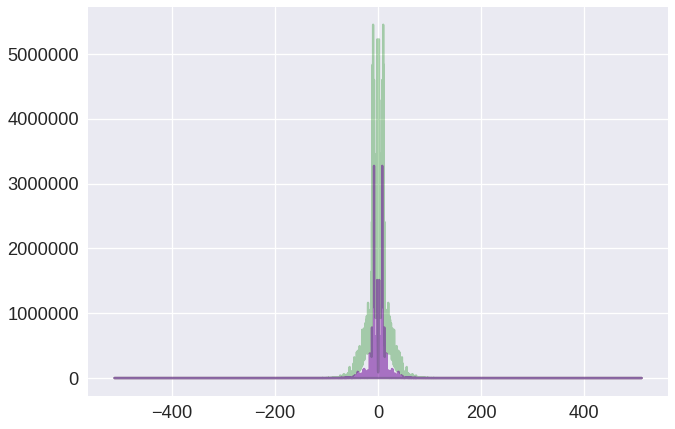

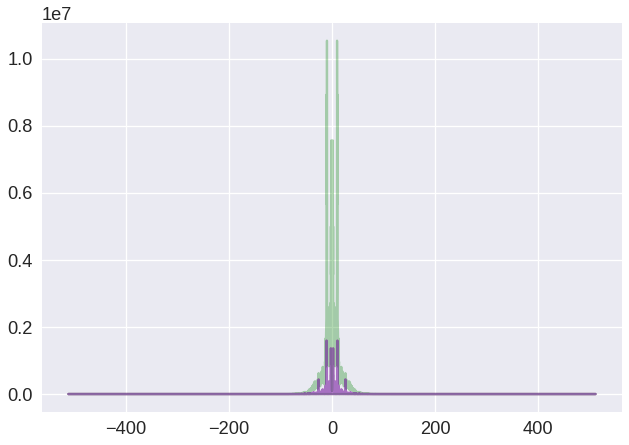

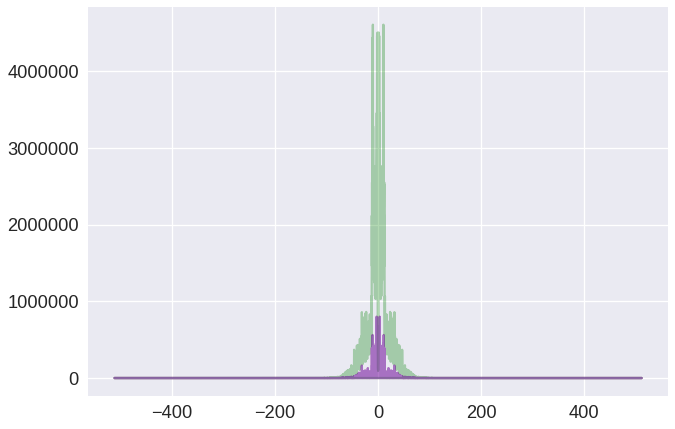

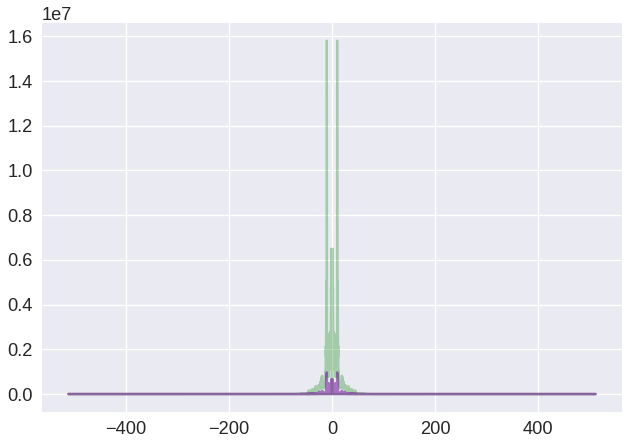

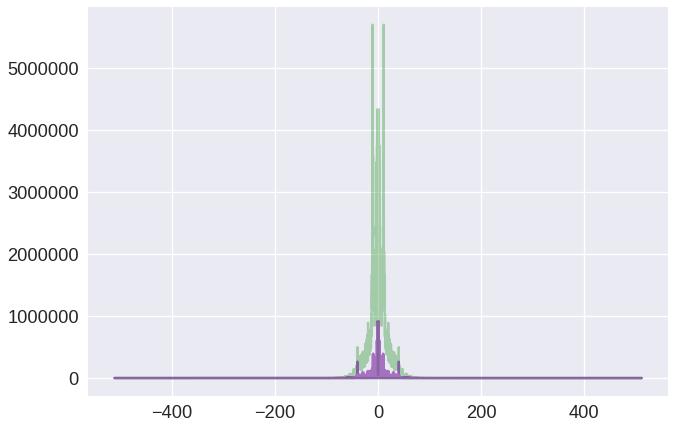

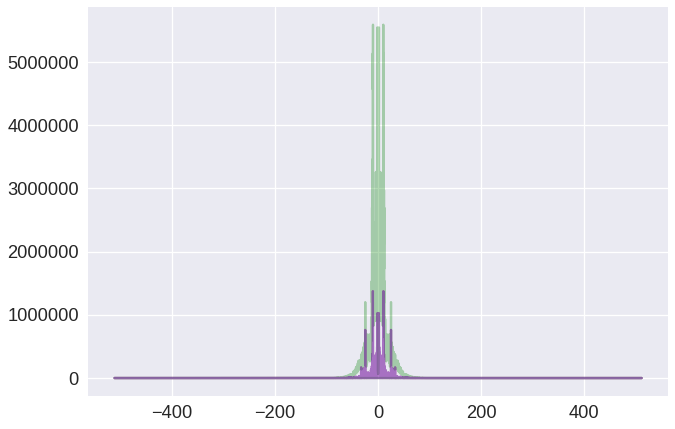

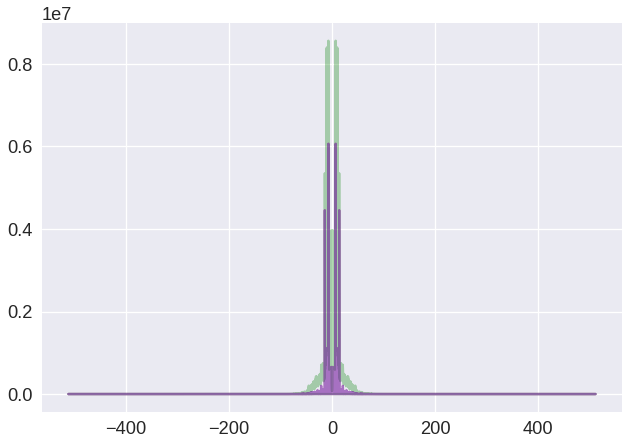

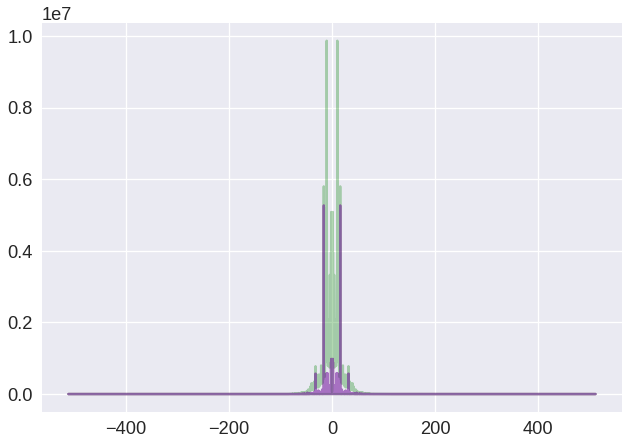

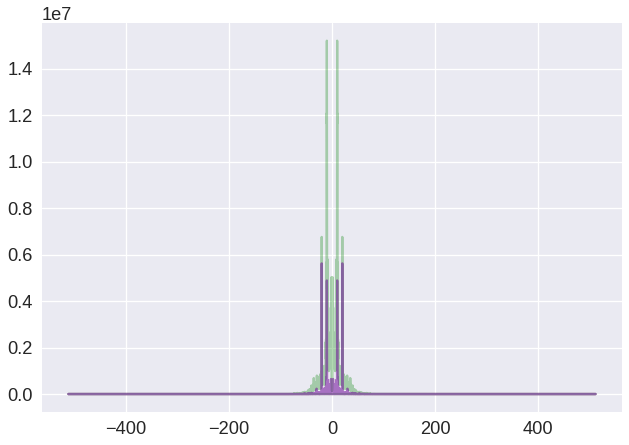

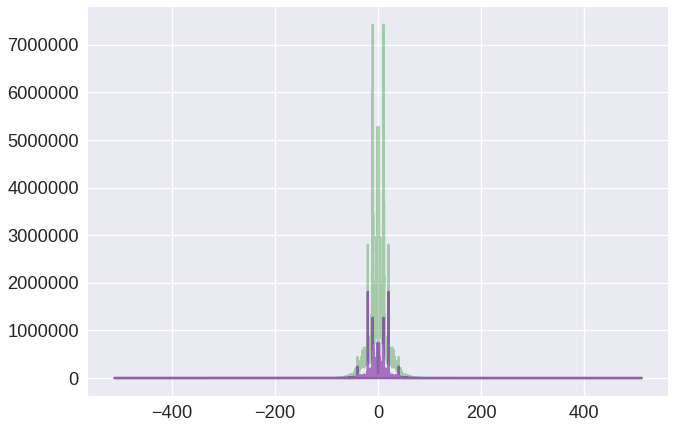

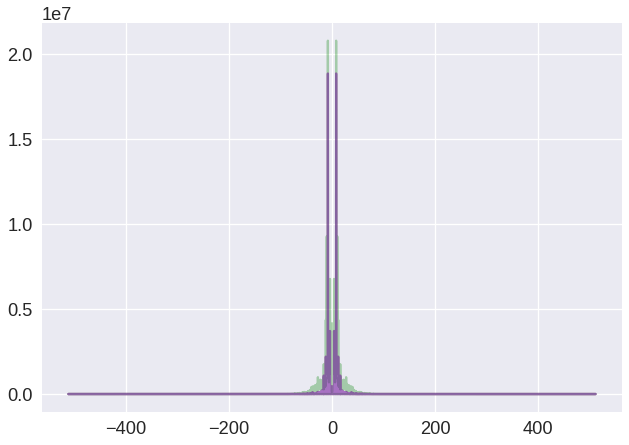

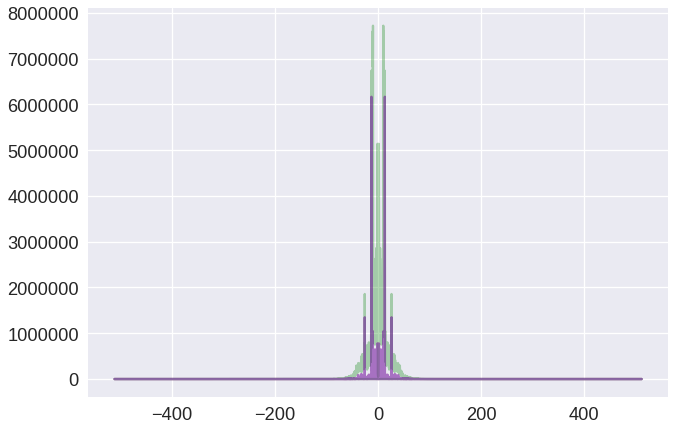

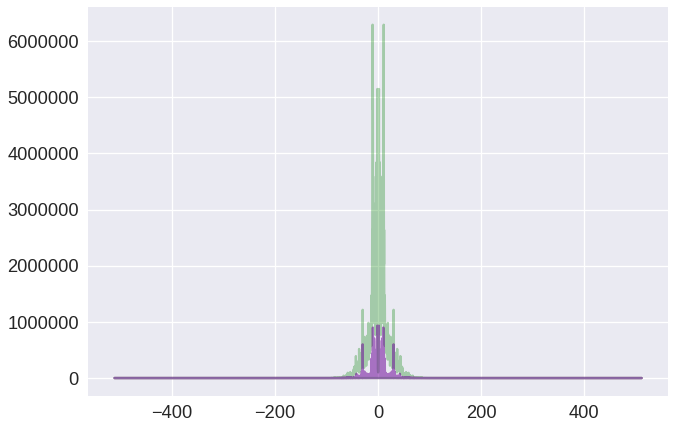

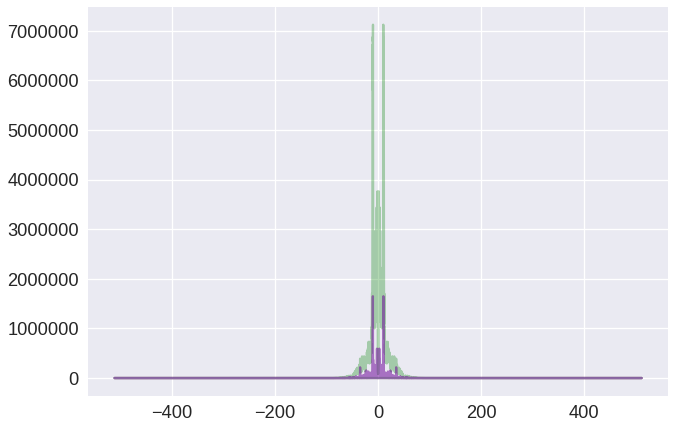

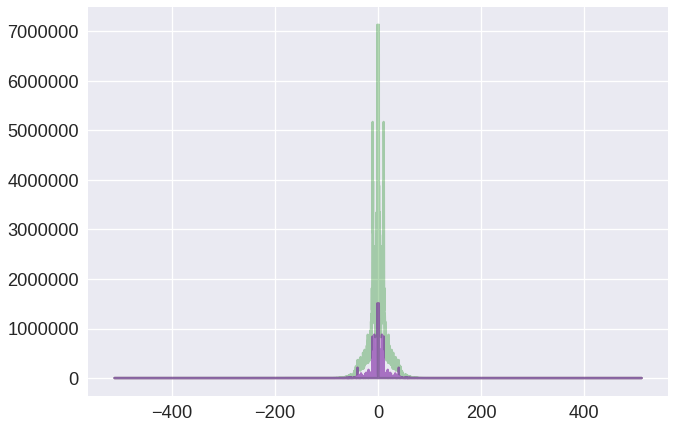

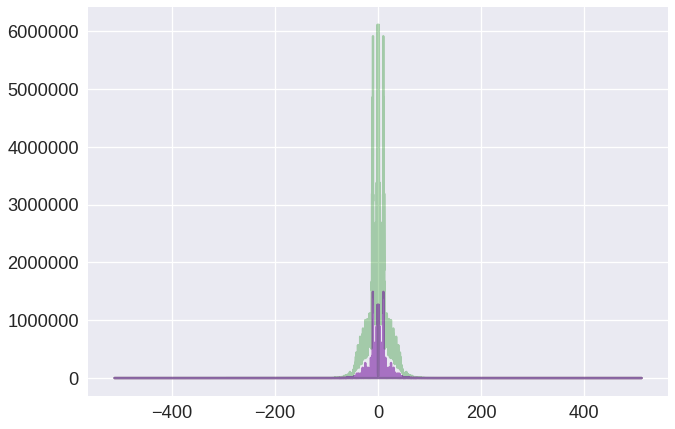

KeyboardInterrupt: ignored

In [0]:
_syg = np.copy(syg)
tags = get_group_tags(_syg, channels_names, fs)

for channel_name in channels_names[:-1][::-1]:
  ch_signal = _syg[channels_names.index(channel_name)]
  for frequency in tags.keys():
    trials = [ch_signal[start:end] for start, end in tags[frequency]]

    F1 = method_1(trials)
    F2 = method_2(trials)
    F3 = method_3(trials)

    freqs = np.fft.fftfreq(len(F1), 1 / 1024)

    plt.plot(freqs, F1, alpha=0.3, c='g')
    plt.plot(freqs, F2, alpha=0.3, c='r')
    plt.plot(freqs, F3, alpha=0.3, c='b')

    plt.show()

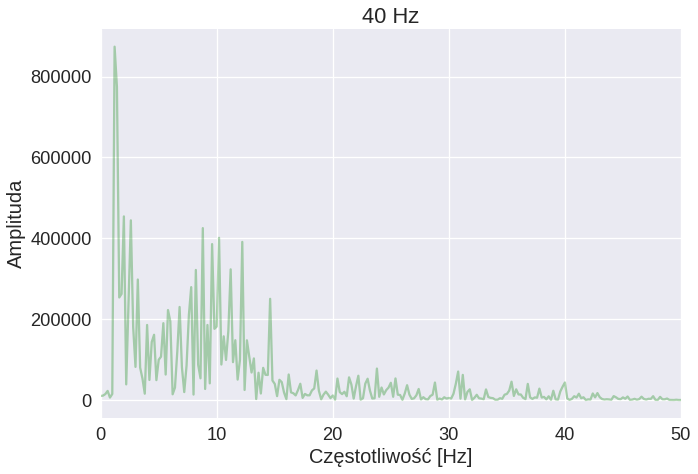

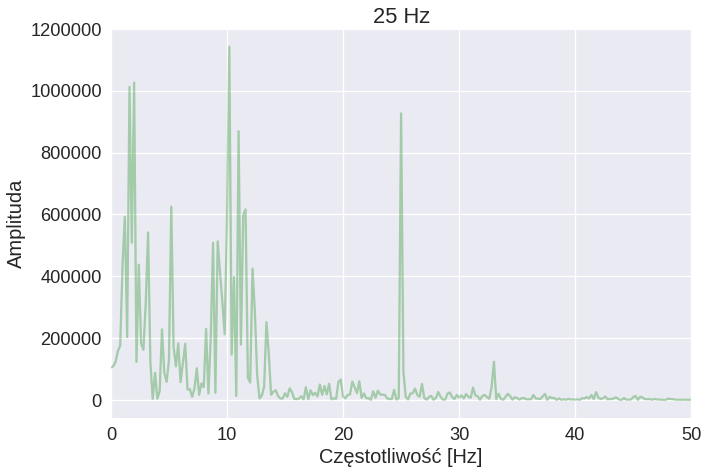

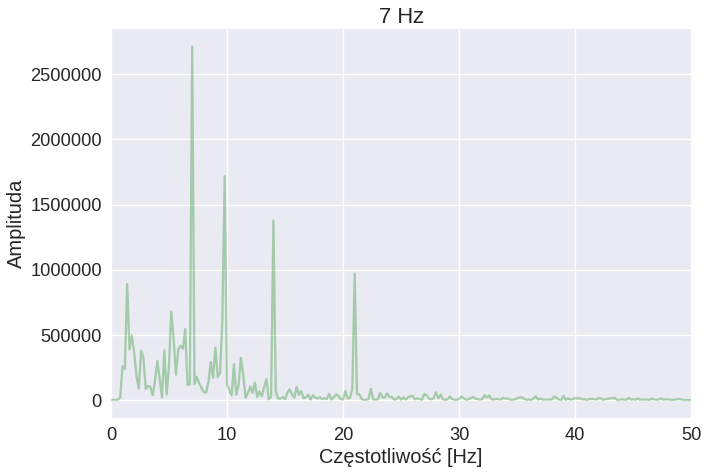

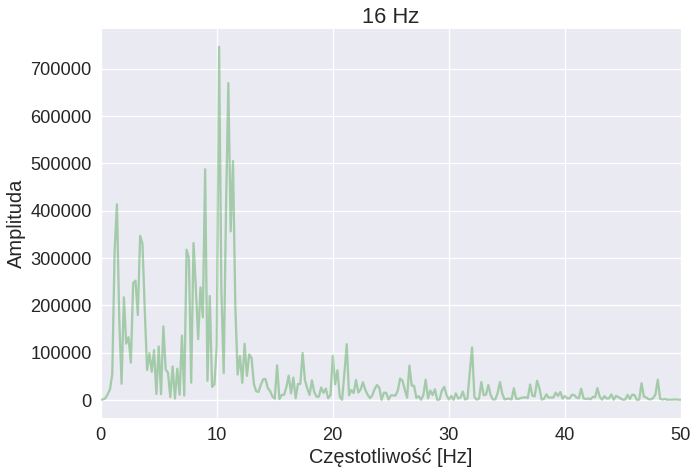

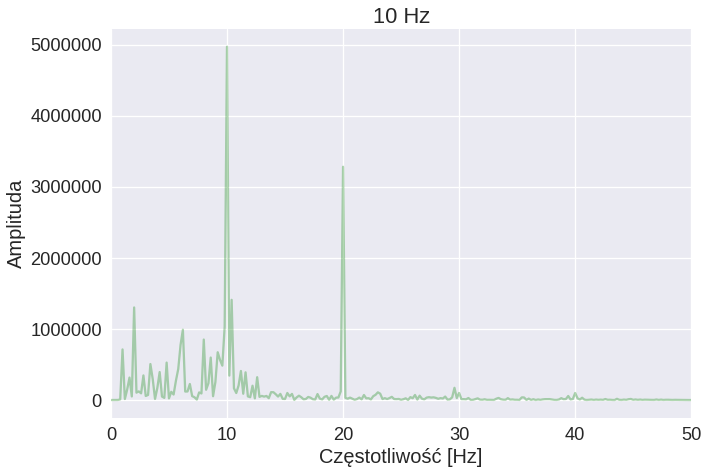

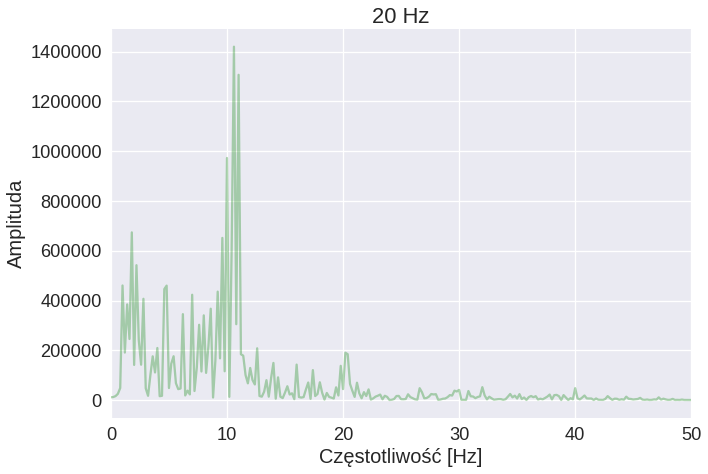

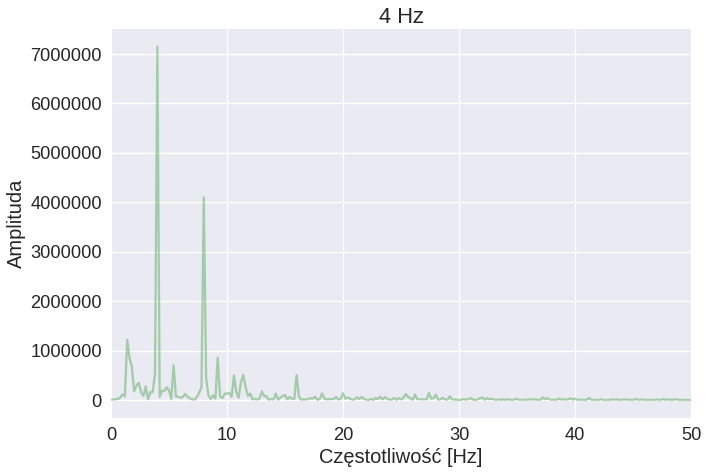

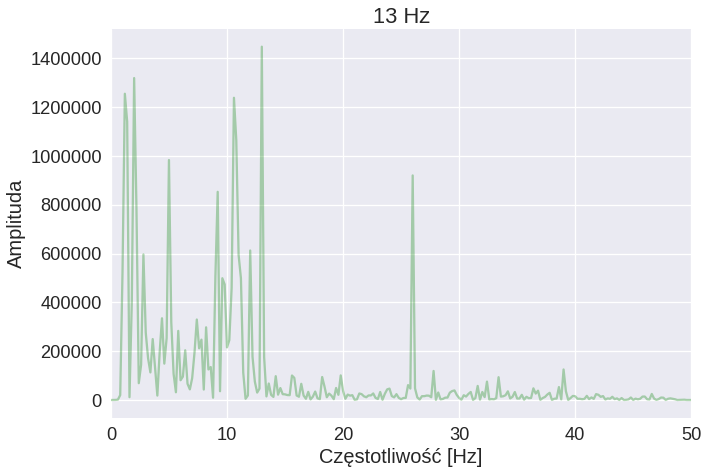

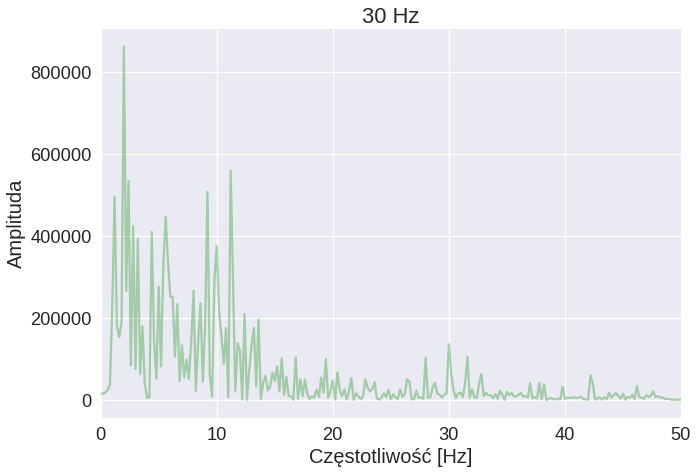

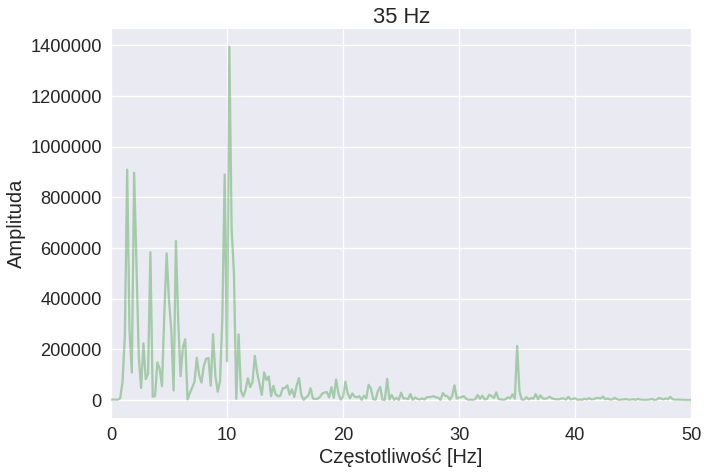

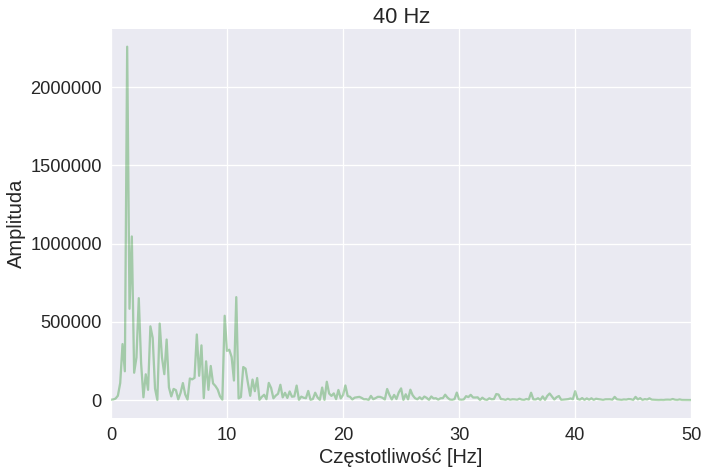

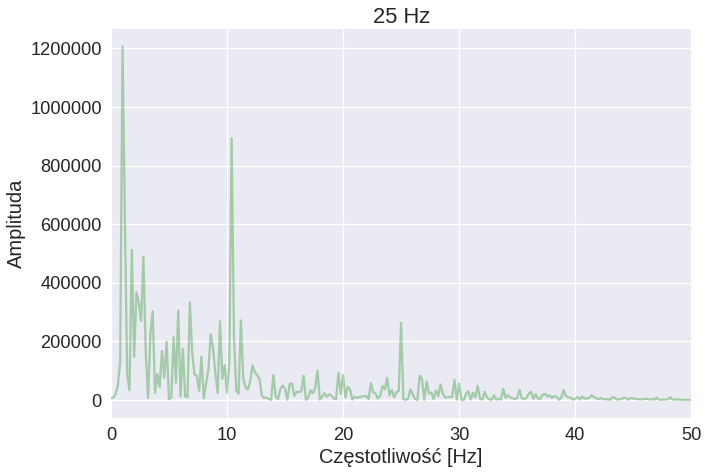

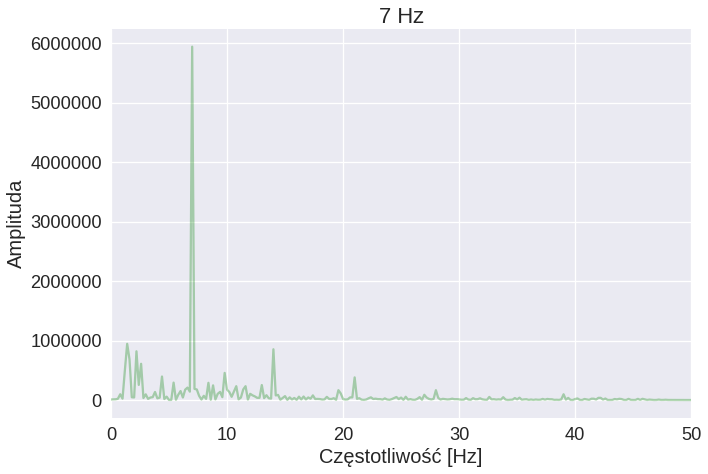

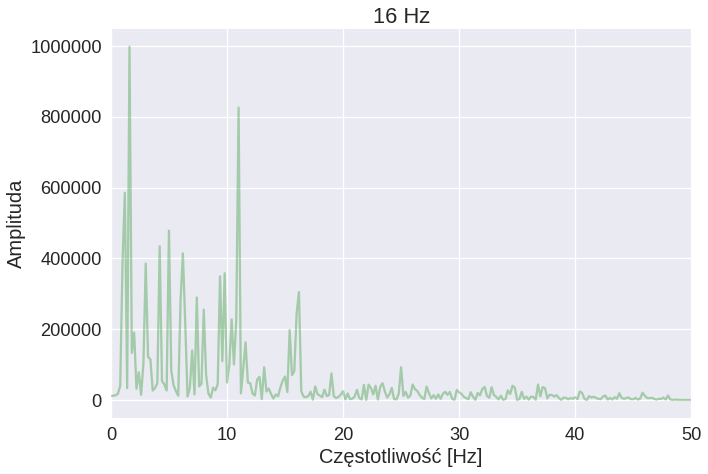

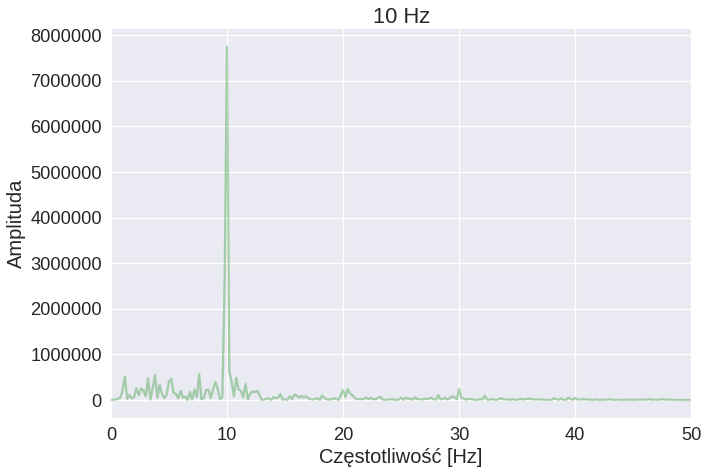

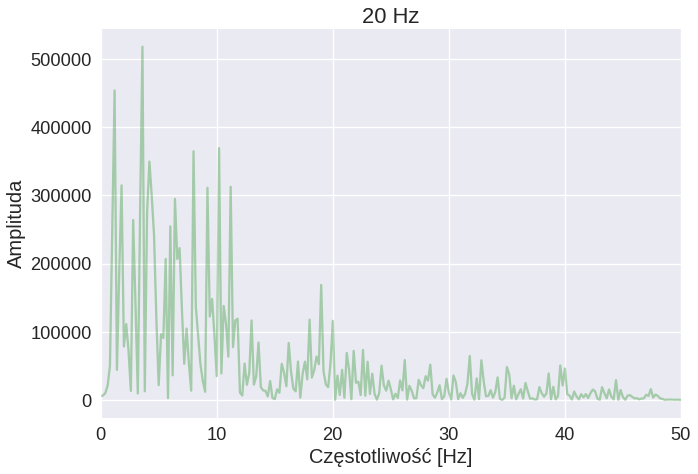

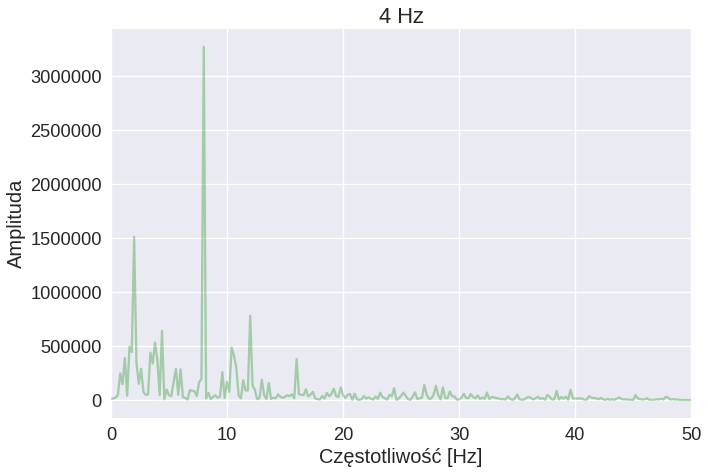

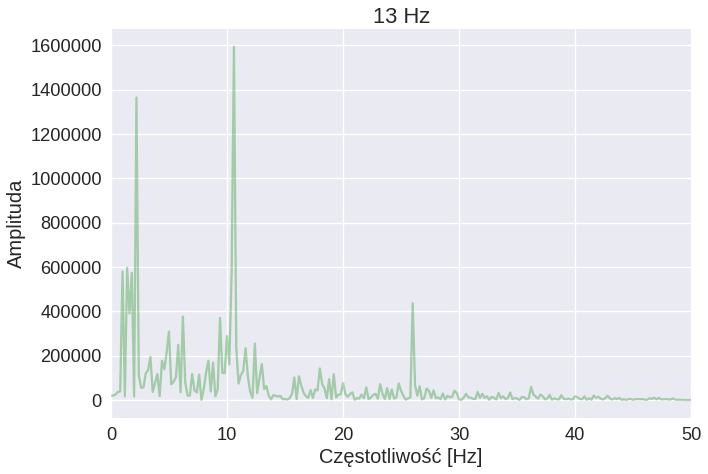

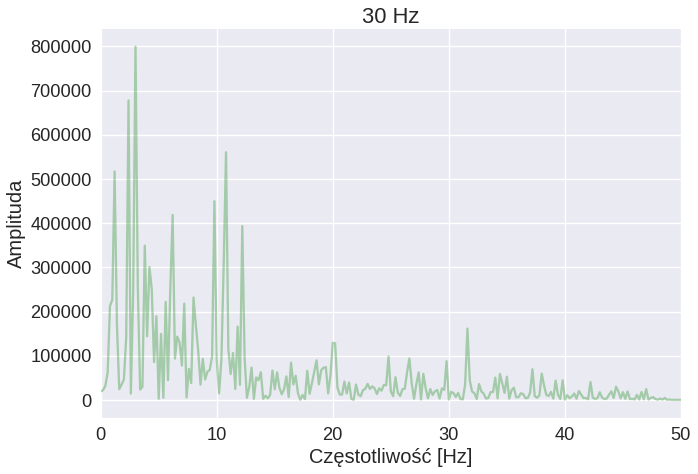

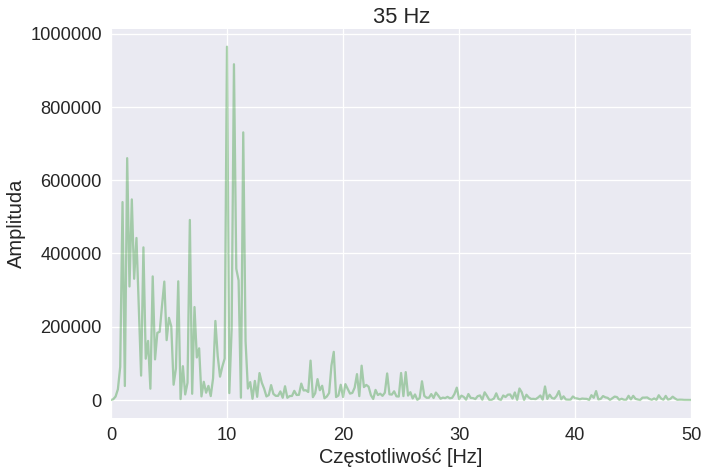

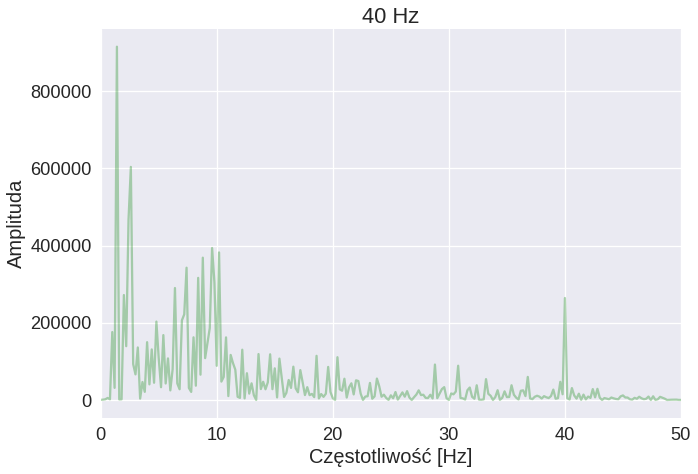

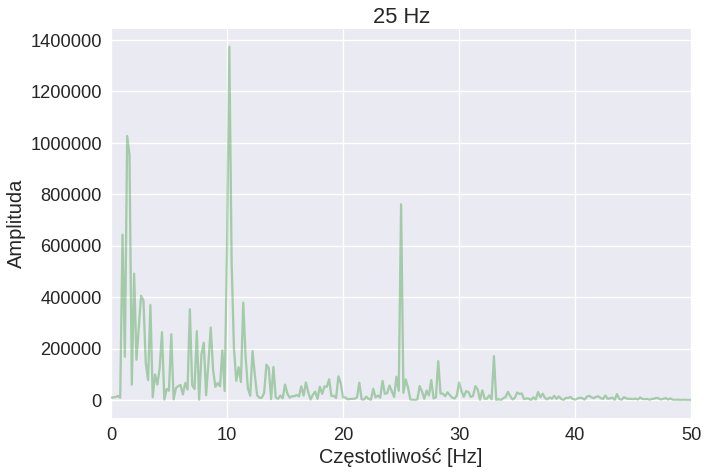

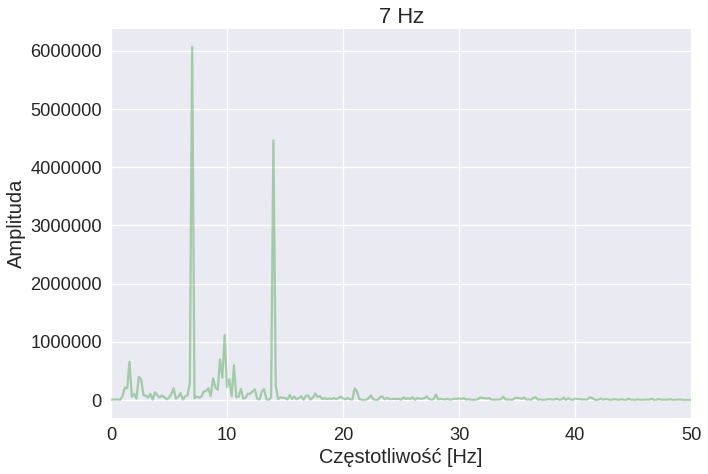

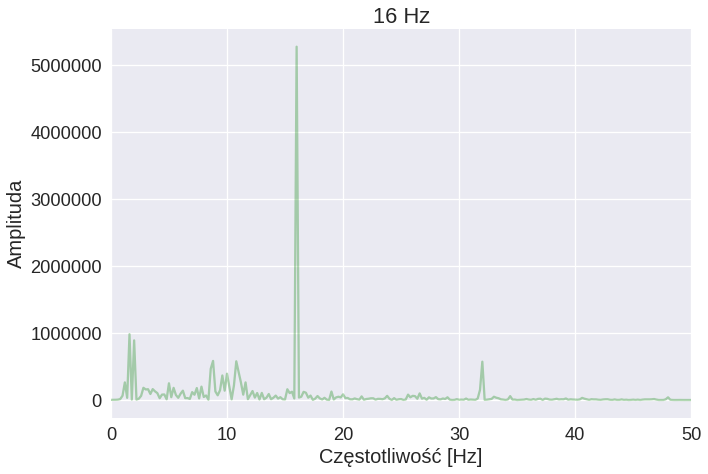

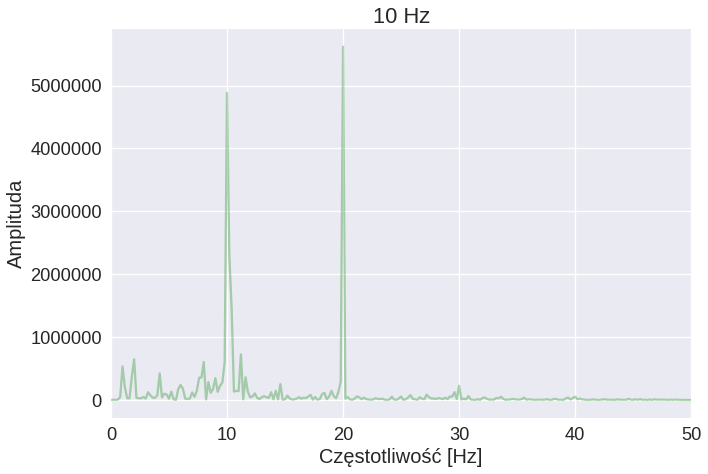

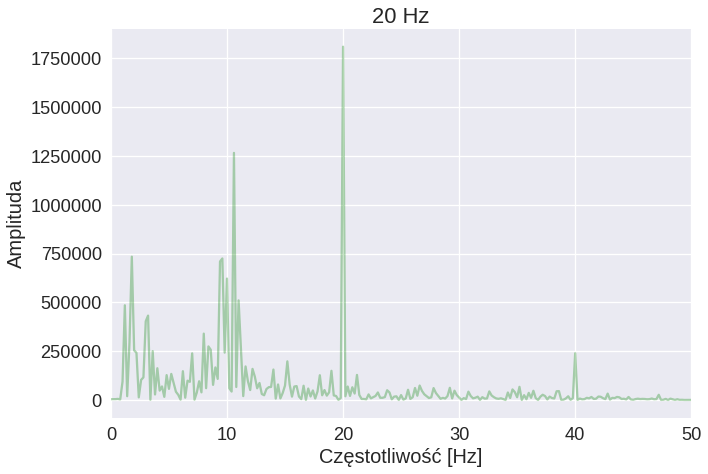

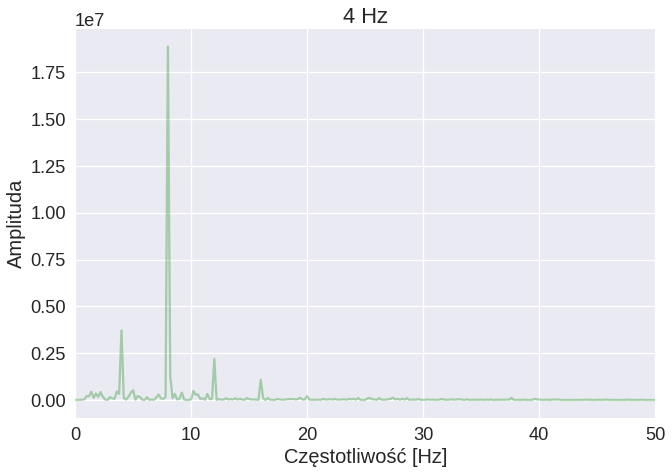

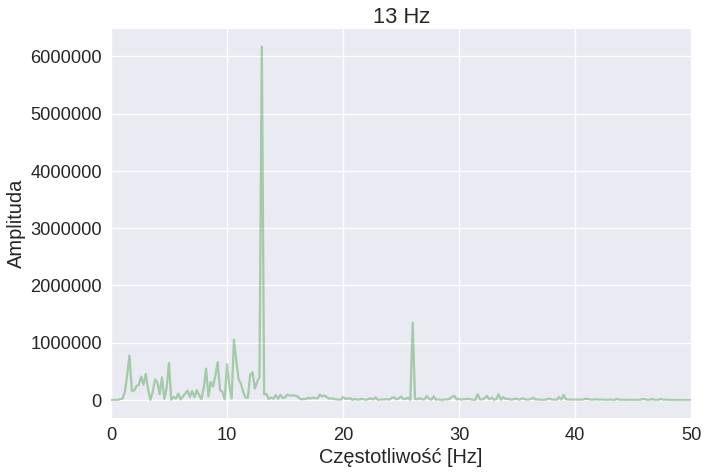

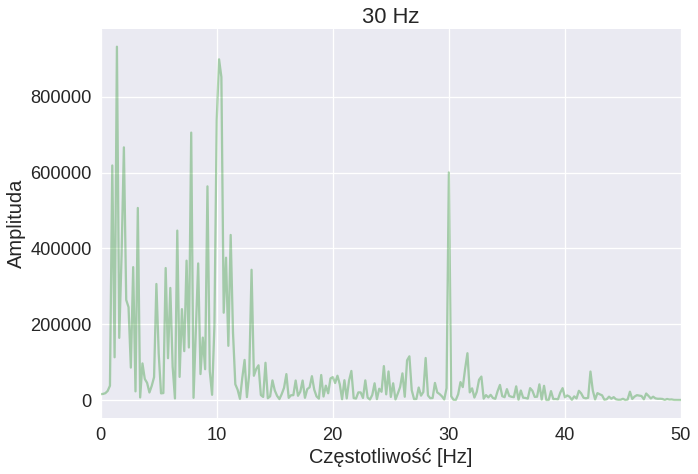

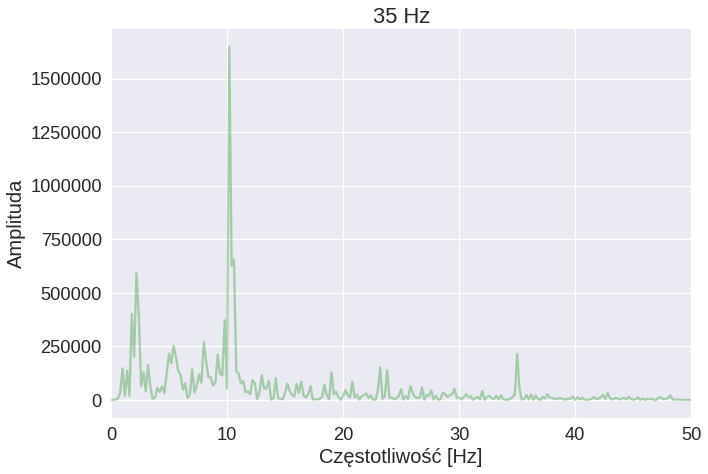

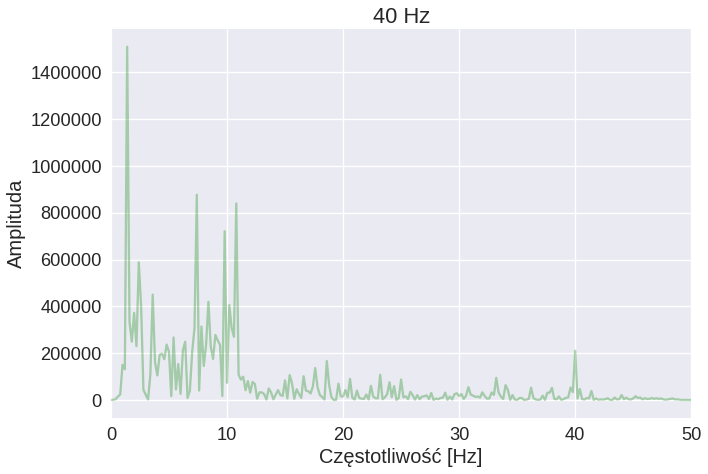

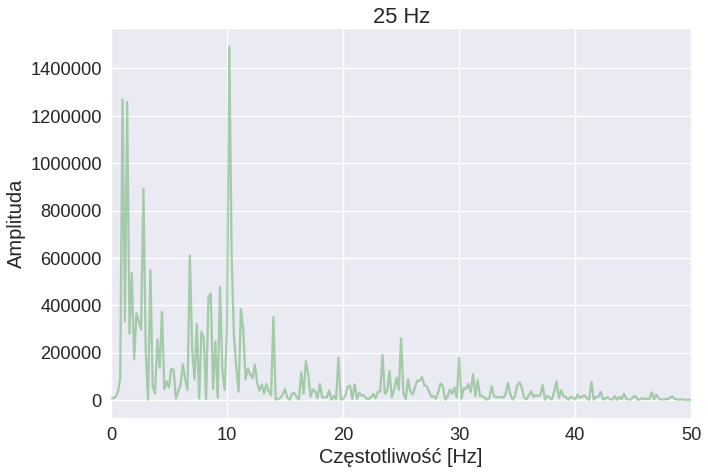

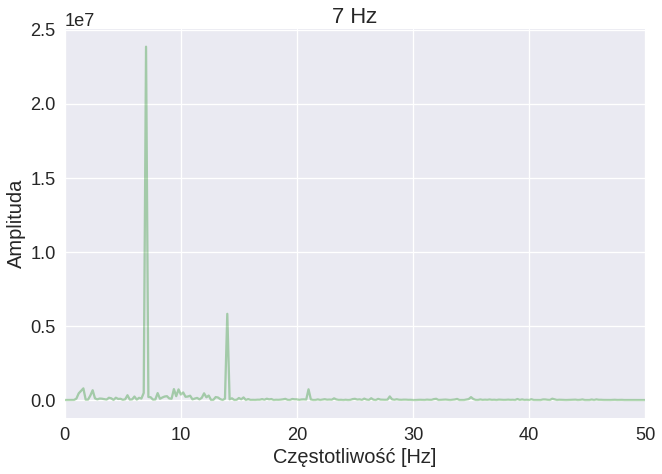

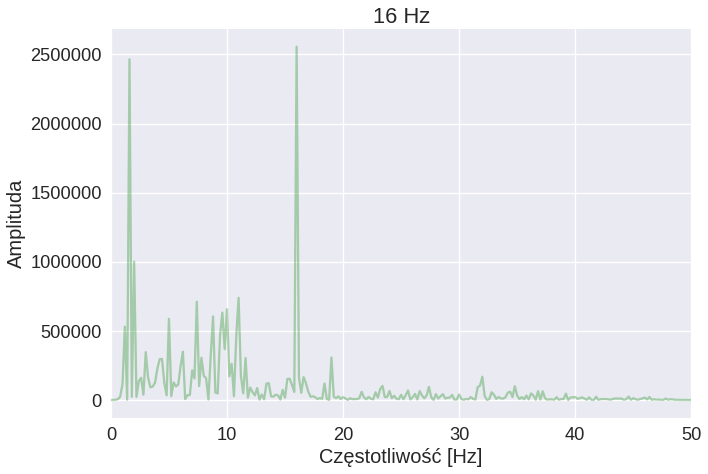

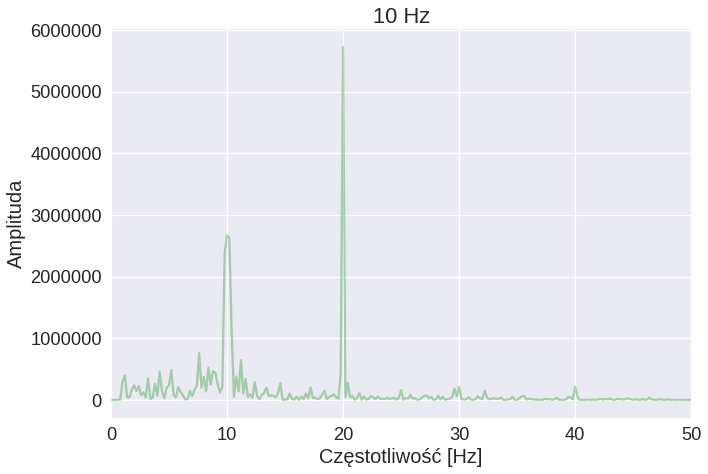

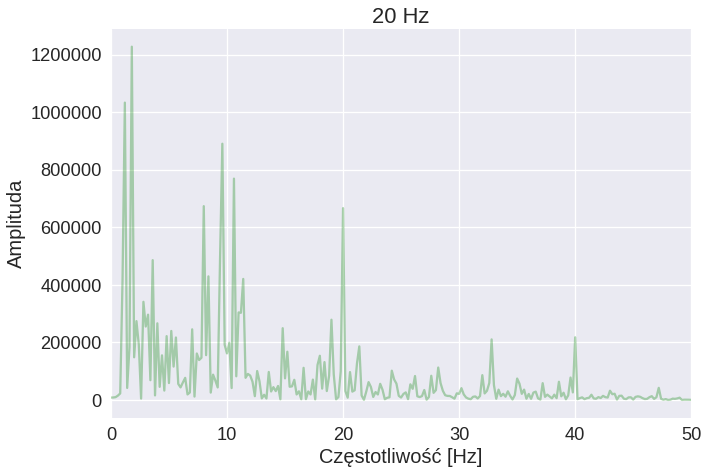

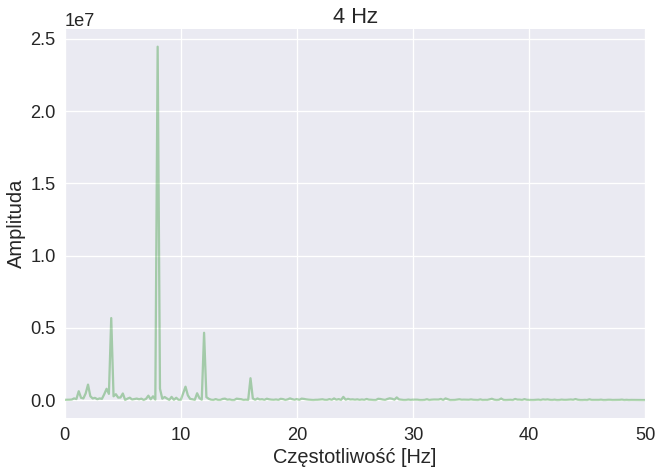

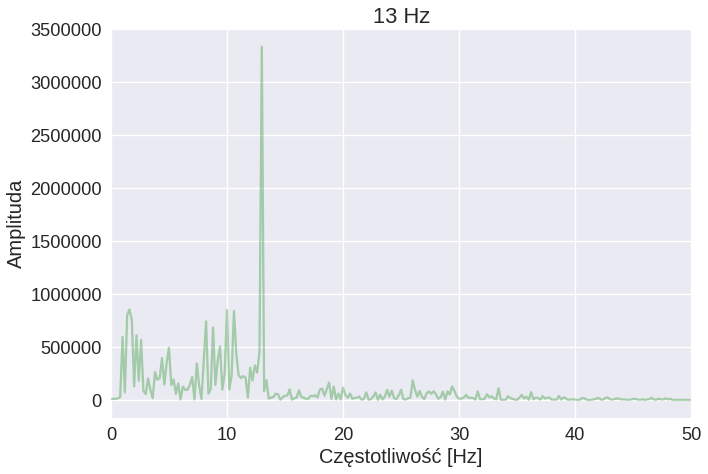

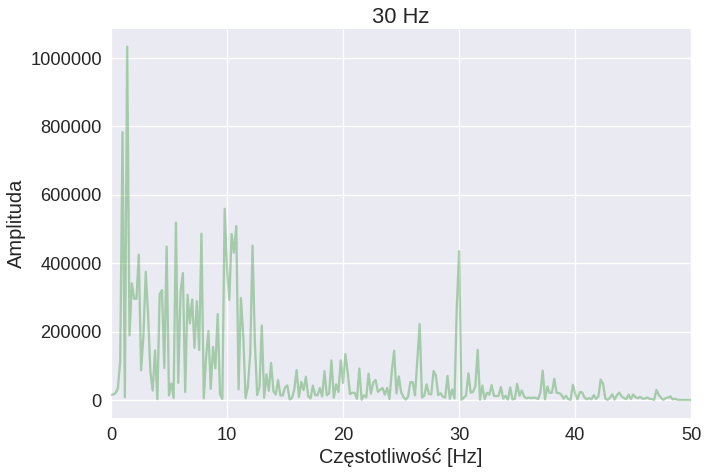

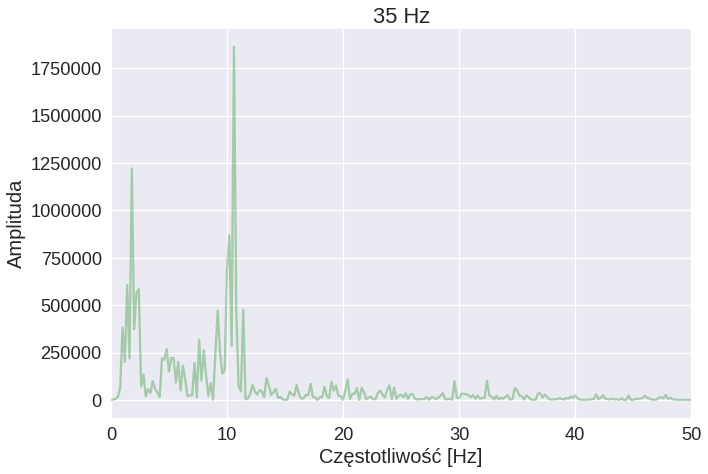

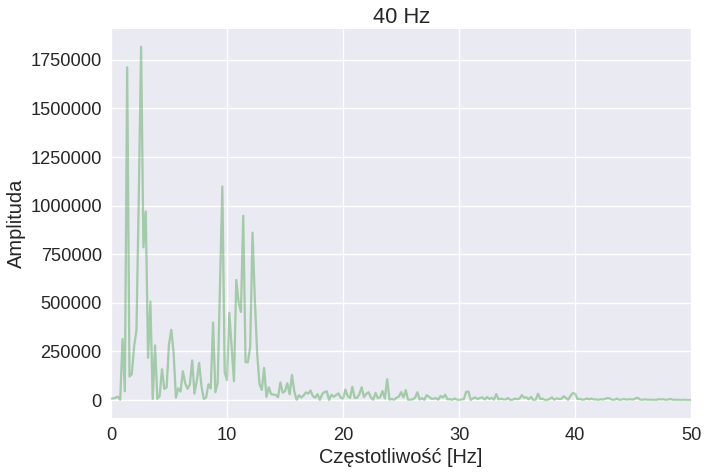

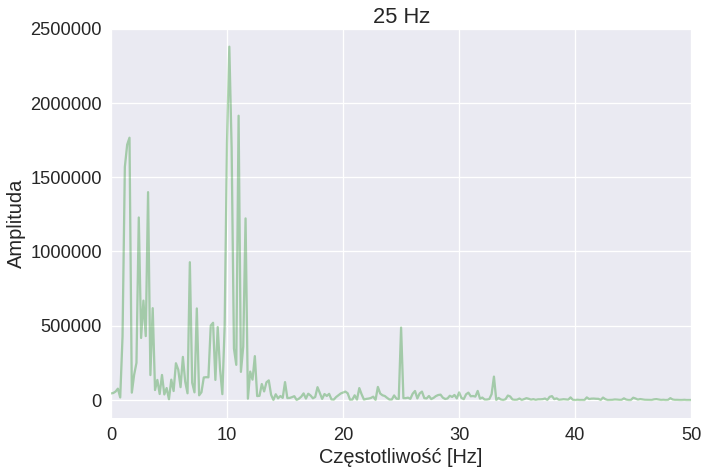

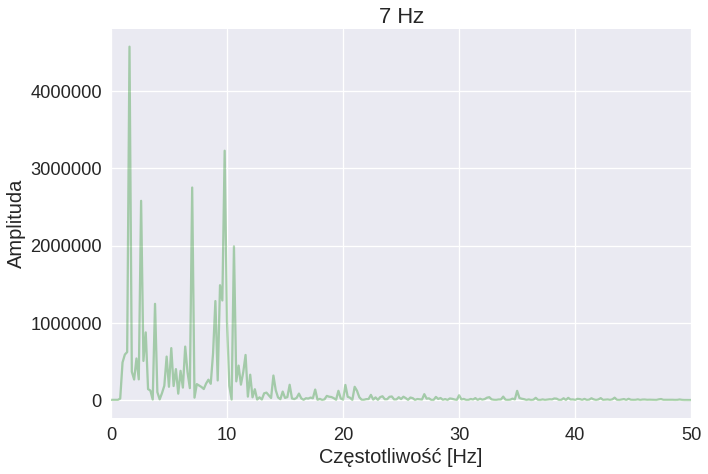

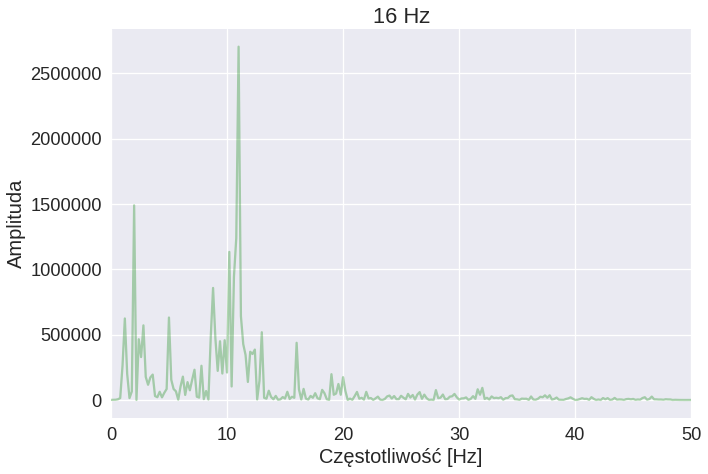

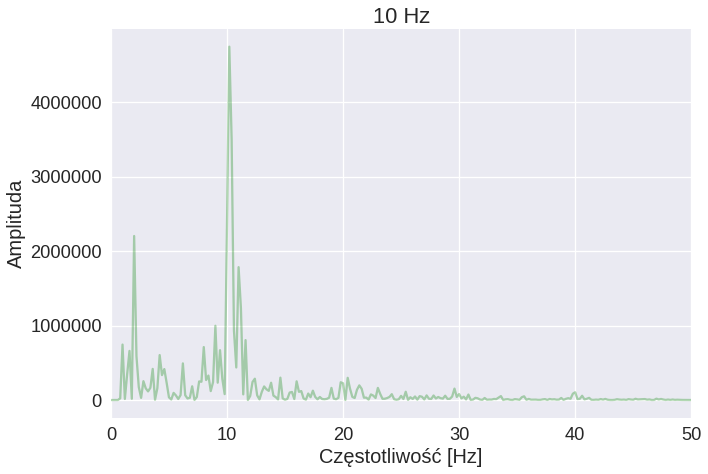

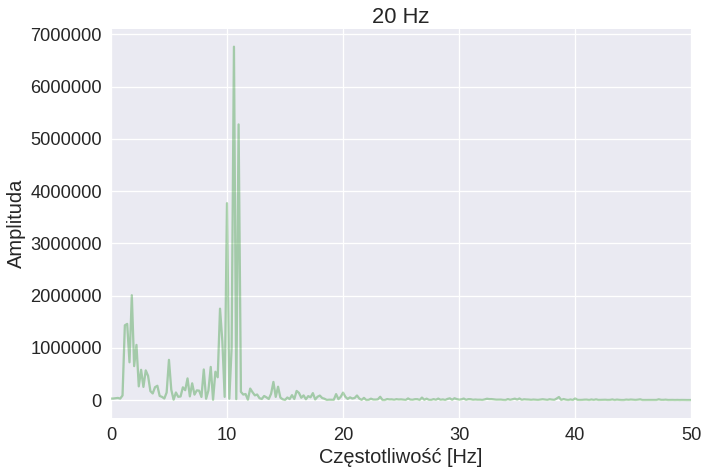

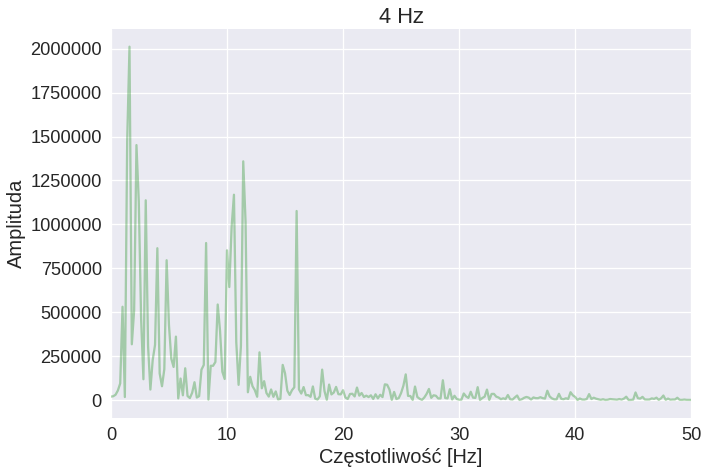

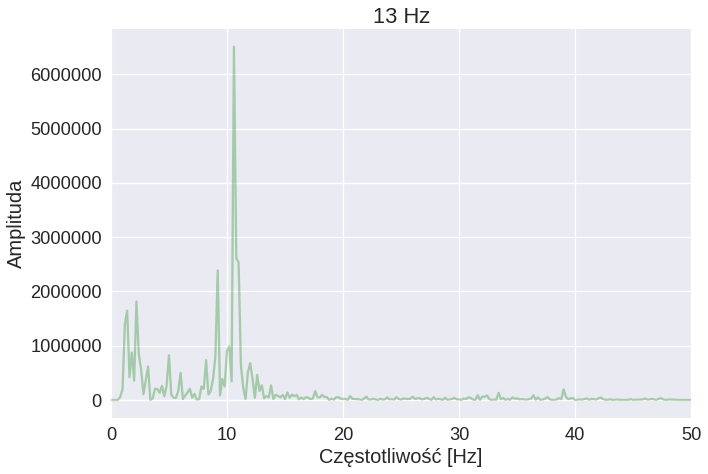

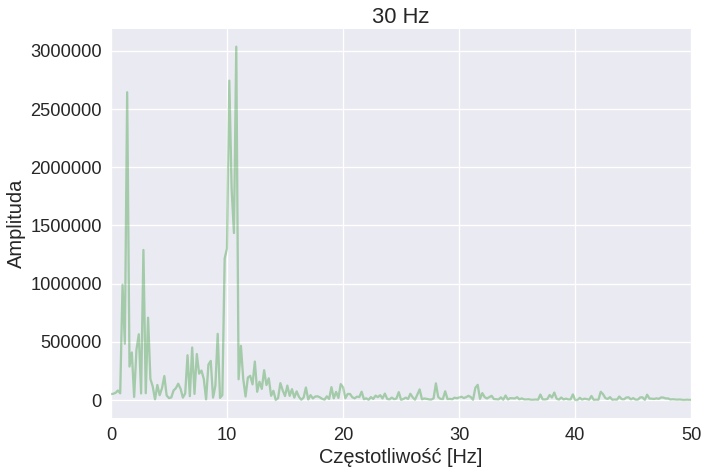

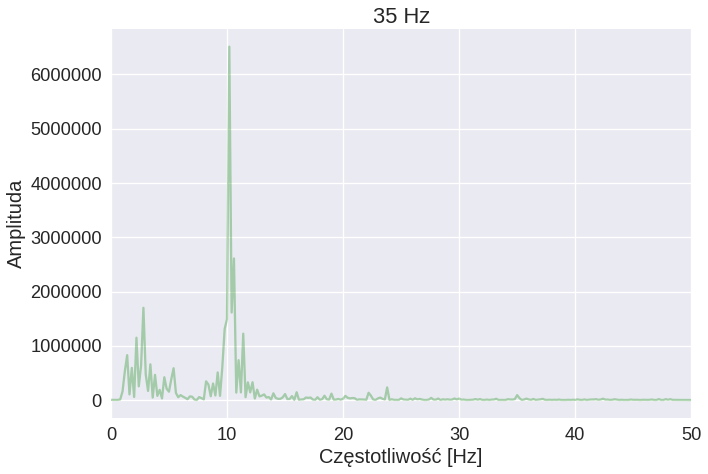

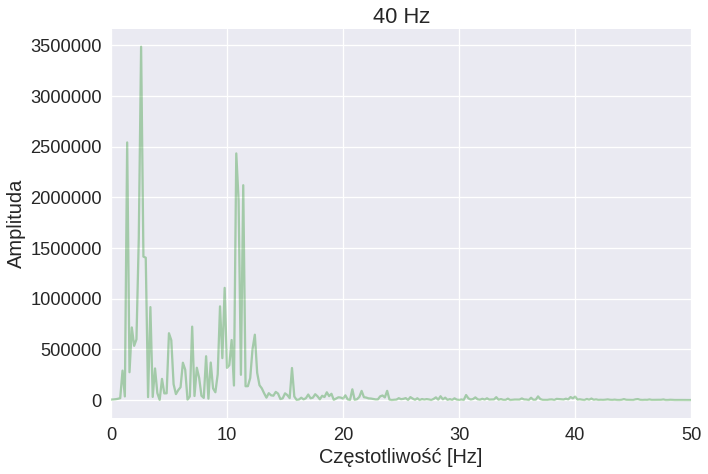

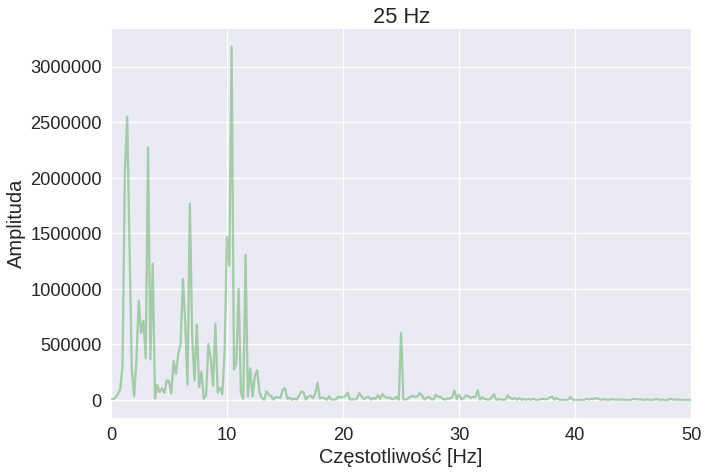

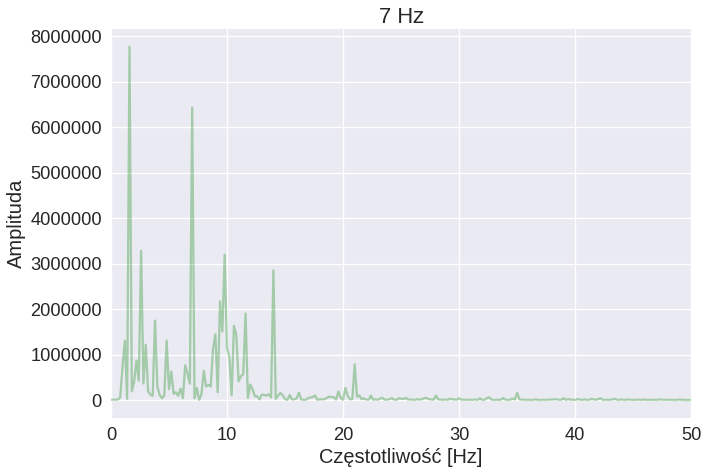

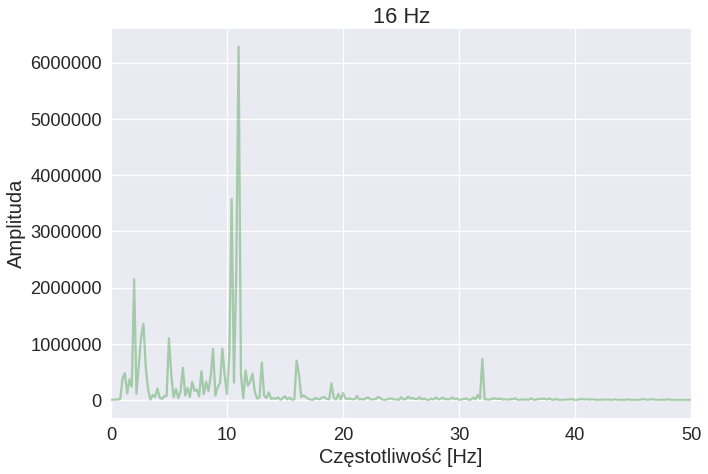

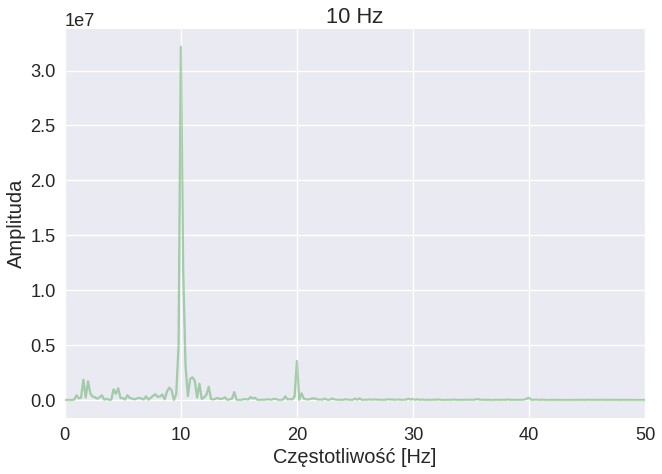

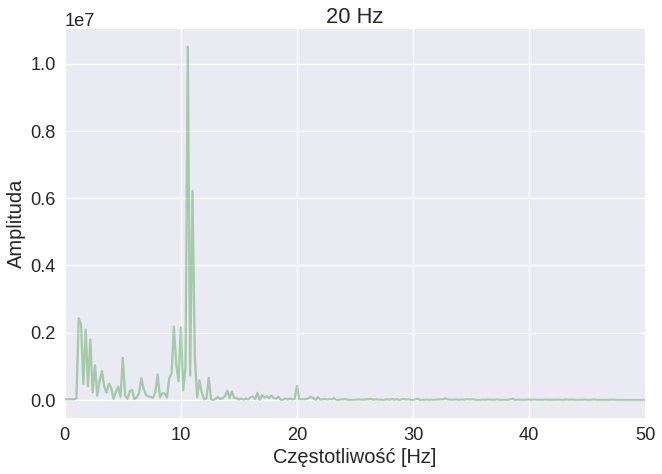

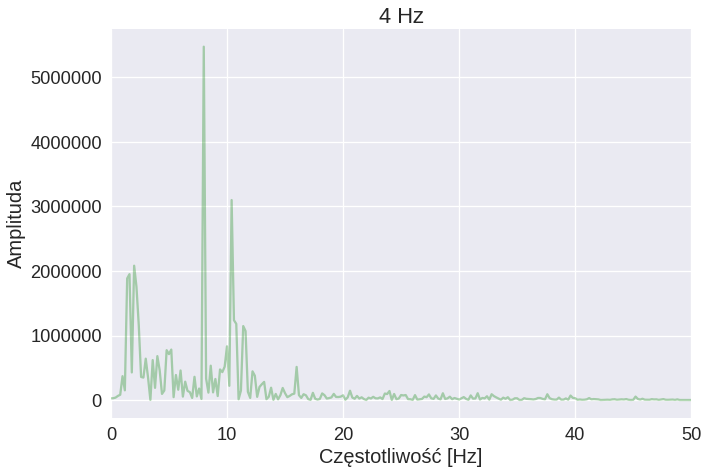

KeyboardInterrupt: ignored

In [0]:
_syg = np.copy(syg)
tags = get_group_tags(_syg, channels_names, fs)

for channel_name in channels_names[:-1][::-1]:
  ch_signal = _syg[channels_names.index(channel_name)]
  for frequency in tags.keys():
    trials = [ch_signal[start:end] for start, end in tags[frequency]]

    F1 = method_2(trials)

    freqs = np.fft.fftfreq(len(F1), 1 / 1024)

    plt.plot(freqs[:len(F1)//2-1], F1[:len(F1)//2-1], alpha=0.3, c='g')
    plt.xlim(0, 50)
    plt.title('{} Hz'.format(frequency))
    plt.xlabel('Częstotliwość [Hz]')
    plt.ylabel('Amplituda')

    plt.show()

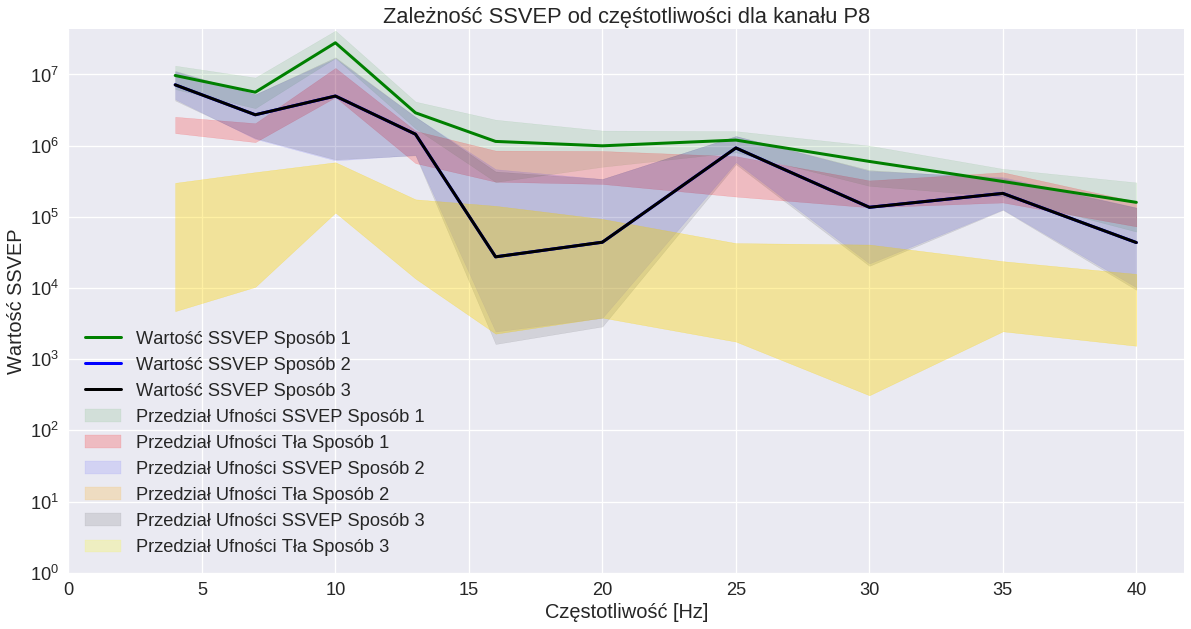

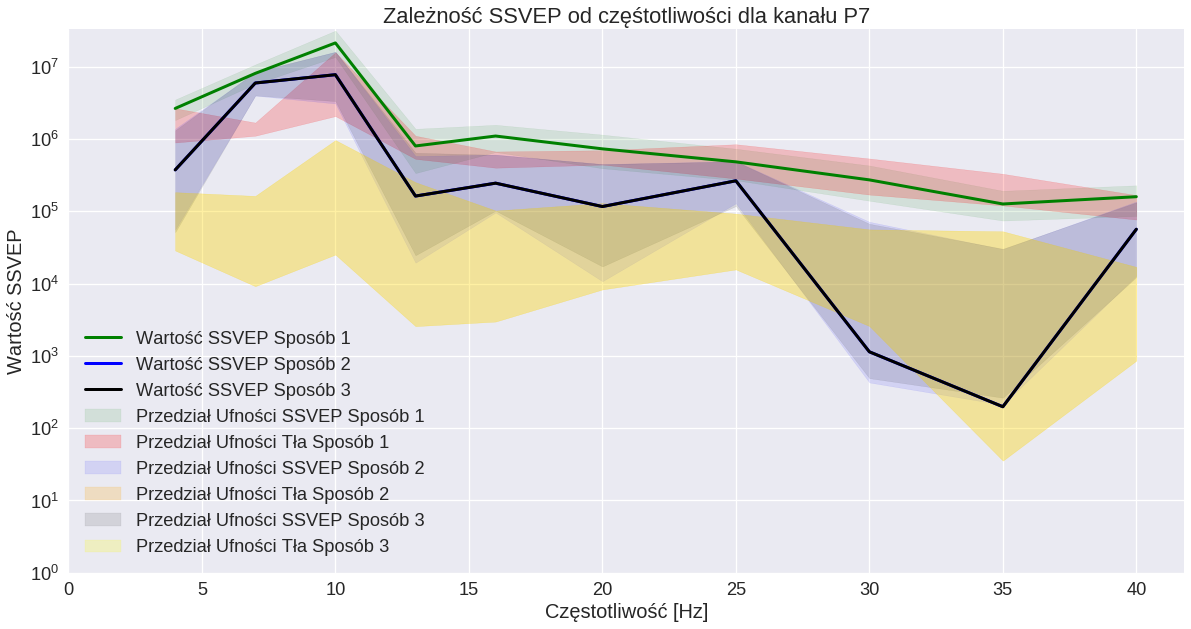

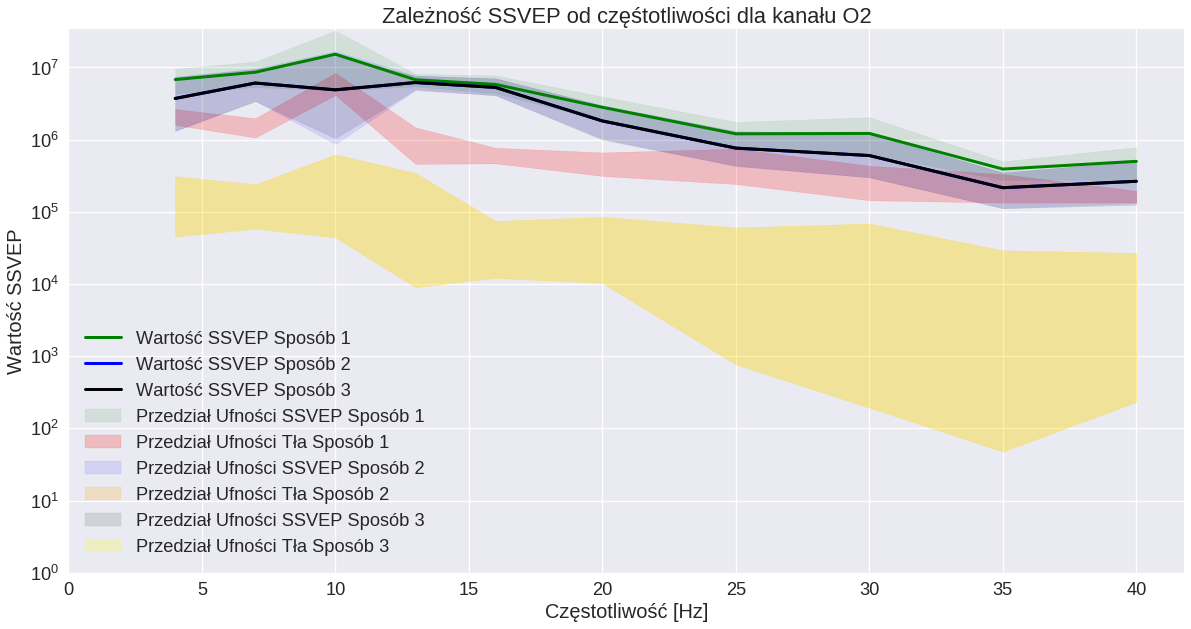

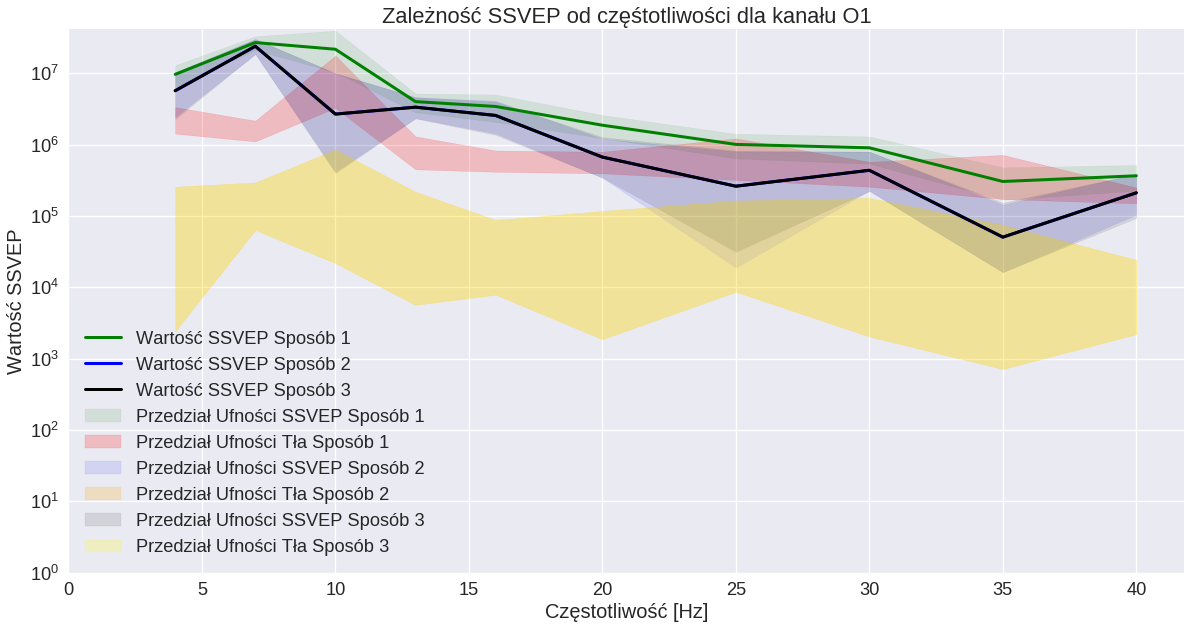

KeyboardInterrupt: ignored

In [0]:
per_channel_1 = method(_syg, channels_names, tags, 1024, method_1)
per_channel_2 = method(_syg, channels_names, tags, 1024, method_2)
per_channel_3 = method(_syg, channels_names, tags, 1024, method_3)

for channel_name in channels_names[:-1][::-1]:
  plt.figure(figsize=(20,10))
  plot_ssvep_curve(*next(per_channel_1), ('g', 'r', 'g'), 'Sposób 1')
  plot_ssvep_curve(*next(per_channel_2), ('b', 'orange', 'b'), 'Sposób 2')
  plot_ssvep_curve(*next(per_channel_3), ('k', 'yellow', 'k'), 'Sposób 3')
  plt.legend()
  plt.show()

## II sposób 


In [0]:
# _syg = np.copy(syg)
# tags = get_group_tags(_syg, channels_names, fs)

# method(_syg, channels_names, tags, 1024, method_2)

## III sposób


In [0]:
# _syg = np.copy(syg)
# tags = get_group_tags(_syg, channels_names, fs)

# method(_syg, channels_names, tags, 1024, method_3)

In [0]:
# Sposób III ładne wykresy


def method_3_plots(x, tags, fs):
  FFs = {}
  Ss = {}
  tags = get_group_tags(syg, channels_names, fs)

  for tag in tags:
    for start, end in tags[tag]:
      dx = x[start:end]
      S = np.fft.fft(dx)
      if tag in FFs:
        FFs[tag][0] += S
        FFs[tag][1] += 1
      else:
        FFs[tag] = [S, 1]
        
      if tag in Ss:
        Ss[tag].append(S)
      else:
        Ss[tag] = [S]
   
  
  meanFFs = {}     
  for f in FFs:
    S, n = FFs[f]
    meanFFs[f] = S/n
    
  freqs = np.fft.fftfreq(dx.size, 1/fs)
  return freqs, meanFFs
 
  


In [0]:
for channel_name in channels_names[:-1]:
  channel =  channels_names.index(channel_name)
  F, S = method_3_plots(syg[channel], tags, fs)
  N = len(S)
  fig = plt.figure(figsize=(15,15))

  fig.suptitle(channel_name)
  for i,f in enumerate(sorted(S)):
    ax = fig.add_subplot(N,1,i+1)
    s = S[f]
    s = np.abs(s)
    ax.title.set_text(f)


    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.plot(F, s)
    plt.xlim(-45,45)
    plt.axvline(-f, c='r', alpha=.5)
    plt.axvline(f, c='r', alpha=.5)
  plt.tight_layout()
  plt.show()

In [0]:
tes1 = [1,2,3,4,6,8,9,16,17]
f_test = 4

def harm(x, f):
  return not bool(x%f) if x!=f else None

def subharm(x, f):
  return not bool(f%x) if x!=f else None


for x in tes1:
  print(x, harm(x,f_test), subharm(x,f_test))


# Ćwiczenia Symulacyjne


###Sin

In [0]:
def sin(f=1, T=1, Fs=128, phi=0):
 
	dt = 1.0/Fs
	x = np.arange(0,T,dt)
	g = np.sin(2*np.pi*f*x + phi)
	return x, g

###Gabor

In [0]:
def gabor(t0=0, sigma=1, omega=1, Fs=128, T=1 ):
  
  x = np.arange(0, T, 1/Fs)
  g = np.empty(len(x))
  
  for i, t in enumerate(x):
    g[i] = np.exp(- np.power(t-t0, 2) / (2 * np.power(sigma, 2))) * np.cos(omega * (t-t0))

  return x, g

#Ćwiczenie 1

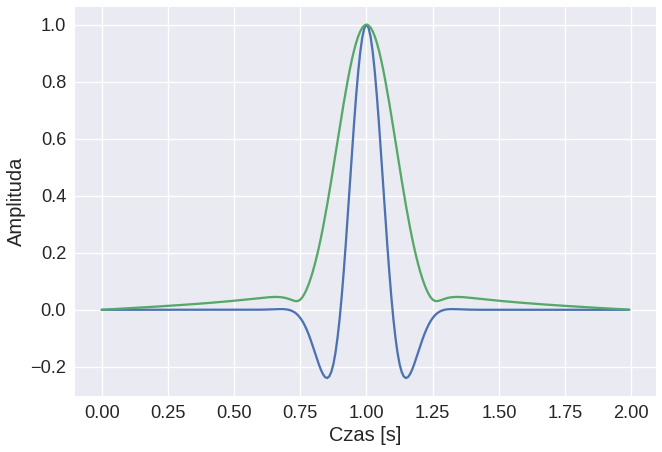

In [0]:
T = 2
x, g = gabor(t0=1, sigma=0.1, omega=16., Fs=128 , T=T)

S = ss.hilbert(g)
amplitude_envelope = np.abs(S)

plt.plot(x, g)
plt.plot(x, amplitude_envelope)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.show()

#Ćwiczenie 2

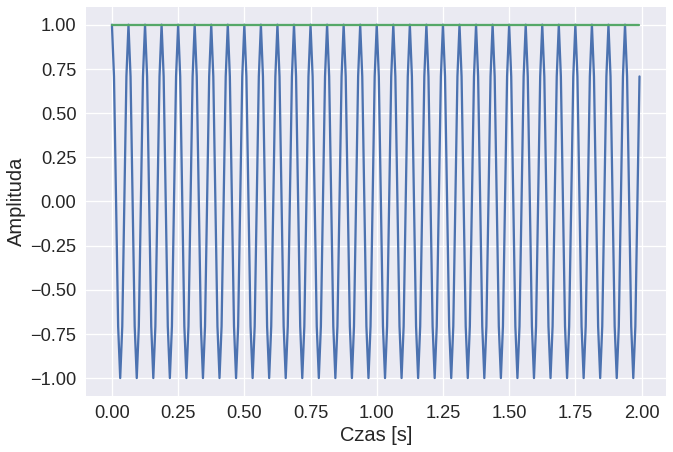

In [0]:
x, s = sin(f=16, T=2, Fs=128, phi=0)
S = ss.hilbert(s)
amplitude_envelope = np.abs(S)

plt.plot(x, s)
plt.plot(x, amplitude_envelope)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.show()

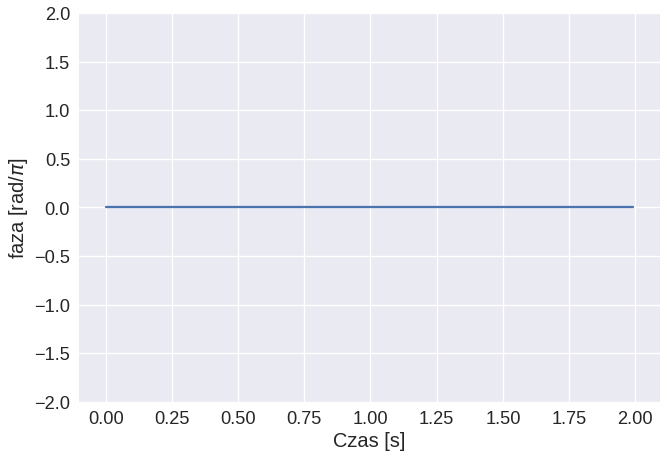

In [173]:
f = 16
x, s = sin(f=f, T=2, Fs=128, phi=0)
S = ss.hilbert(s)
instantaneous_phase = np.unwrap(np.angle(S))
instantaneous_phase /= np.pi
instantaneous_phase = 0.5 + instantaneous_phase - 2*f*x # Wynika ze wzoru z brain.fuw.edu.pl

plt.plot(x, instantaneous_phase)
plt.xlabel('Czas [s]')
plt.ylabel('faza [rad/$\pi$]')
plt.ylim(-2, 2)
plt.show()

#Ćwiczenie 3


In [0]:
t1, s1 = sin(f=32, T=2, Fs=128, phi=0)
t2, s2 = sin(f=32, T=2, Fs=128, phi=np.pi*0.25)

phase_1 = np.unwrap(np.angle(ss.hilbert(s1)))
phase_2 = np.unwrap(np.angle(ss.hilbert(s2)))

print((phase_2-phase_1)/(np.pi))

[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 

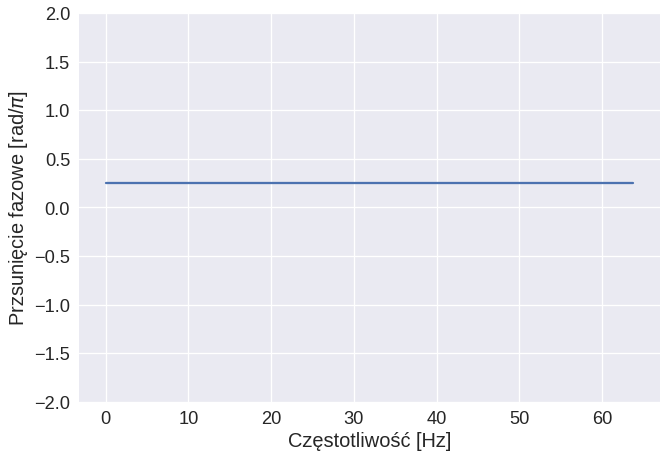

In [0]:
t1, s1 = sin(f=32, T=2, Fs=128, phi=0)
t2, s2 = sin(f=32, T=2, Fs=128, phi=np.pi*0.25)

t3, s3 = sin(f=10, T=2, Fs=128, phi=0)
t4, s4 = sin(f=15, T=2, Fs=128, phi=np.pi*0.5)

f = np.arange(0, 128//2, (128//2)/(2*128))

phase_1 = np.unwrap(np.angle(ss.hilbert(s1)))
phase_2 = np.unwrap(np.angle(ss.hilbert(s2)))

diff = (phase_2-phase_1)/(np.pi)

plt.plot(f, diff)
plt.ylim(-2, 2)
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Przsunięcie fazowe [rad/$\pi$]')
plt.show()

In [0]:

help(ss.hilbert)


Help on function hilbert in module scipy.signal.signaltools:

hilbert(x, N=None, axis=-1)
    Compute the analytic signal, using the Hilbert transform.
    
    The transformation is done along the last axis by default.
    
    Parameters
    ----------
    x : array_like
        Signal data.  Must be real.
    N : int, optional
        Number of Fourier components.  Default: ``x.shape[axis]``
    axis : int, optional
        Axis along which to do the transformation.  Default: -1.
    
    Returns
    -------
    xa : ndarray
        Analytic signal of `x`, of each 1-D array along `axis`
    
    See Also
    --------
    scipy.fftpack.hilbert : Return Hilbert transform of a periodic sequence x.
    
    Notes
    -----
    The analytic signal ``x_a(t)`` of signal ``x(t)`` is:
    
    .. math:: x_a = F^{-1}(F(x) 2U) = x + i y
    
    where `F` is the Fourier transform, `U` the unit step function,
    and `y` the Hilbert transform of `x`. [1]_
    
    In other words, the negative h

#Ćwiczenie 4

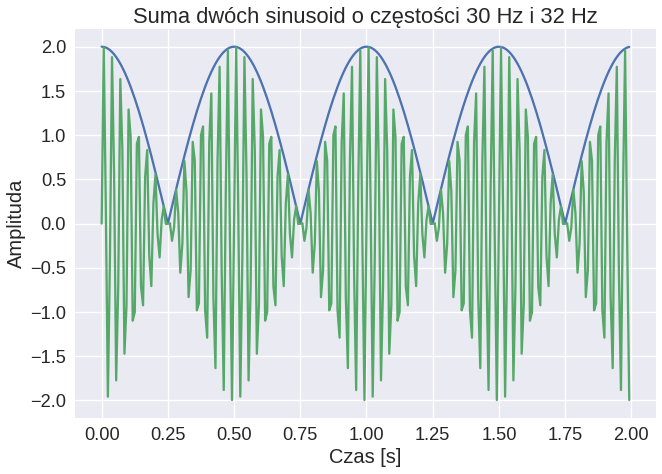

In [0]:
t1, s1 = sin(f=30, T=2, Fs=128, phi=0)
t2, s2 = sin(f=32, T=2, Fs=128, phi=0)

t, s = t1, s1 + s2

plt.plot(t, np.abs(ss.hilbert(s)))
plt.title('Suma dwóch sinusoid o częstości 30 Hz i 32 Hz')
plt.ylabel('Amplituda')
plt.xlabel('Czas [s]')
plt.plot(t, s)
plt.show()

# Ćwiczenia na danych pomiarowych

W zebranych sygnałach SSVEP wybierz zapisy dla trzech różnych częstości stymulacji (po jednym dla każdej częstości). Do analizy wybierz trzy kanały EEG, dla których sygnał SSVEP jest a) bardzo wyraźny; b) widoczny, ale słabszy; c) w zasadzie niewidoczny. Do analizy wybierz fragmenty od 2 sekund przed rozpoczęciem stymulacji do 2 sekund po jej zakończeniu.

Dla każdej wybranej częstości stymulacji wybrane kanały EEG przefiltruj filtrem wąskopasmowym przepuszczającym częstości skupione wokół tej częstości stymulacji. Do przefiltrowanych sygnałów zastosuj transformację Hilberta, wyznacz amplitudę i częstość chwilową. Wyznacz fazę chwilową dla ω0 równej częstości stymulacji. Wypróbuj dwa sposoby filtrowania: „w jedną stronę” (filter) i „w obie strony” (filtfilt).

Wyrysuj przefiltrowane sygnały wraz z wyliczoną amplitudą chwilową. Do rysunku dodaj wykres sygnału triggera aby widać było początek i koniec stymulacji. Narysuj też wykres zależności częstości chwilowej i fazy chwilowej od czasu. 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

# https://drive.google.com/drive/folders/1udb0q02PnAZzvVgctE4qiO0nDt1yXXIV?usp=sharing

In [0]:
import scipy.signal as ss

filenames = ["ssvep_1", "ssvep_2"]

for finename in filenames:
  extentions = ['.xml', '.raw', '.tag']

  mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)
  fs = int(float(mgr.get_param("sampling_frequency")))
  num_of_channels = int(mgr.get_param("number_of_channels"))
  channels_names = mgr.get_param("channels_names")

  raw_syg = mgr.get_microvolt_samples()
  t = np.arange(raw_syg.shape[1])/fs
  print('channels :', channels_names)

  montage_syg = np.copy(raw_syg)
  montage_syg[:-3,:] -= (raw_syg[channels_names.index('TP9'),:] + raw_syg[channels_names.index('TP10'),:])/2


  ssvep_singal = []
  ssvep_channels = ['O1', 'Pz', 'Fp1', 'd1', 'd2'] 

  for channel in ssvep_channels:
    ds = montage_syg[channels_names.index(channel),:]
    ssvep_singal.append(ds)

  syg = np.array(ssvep_singal)

  tags = []
  groups = get_group_tags(syg, ssvep_channels, fs, smallest_frequency=4, trial_length=5)
  for key, val in groups.items():
    new_val = []
    for elem in val:
      start, end = elem
      start -= 2 * fs
      end += 2 * fs
      tag = start, end
      new_val.append(tag)
    data = (key, val, new_val)
    print(data)
    tags.append(data)


  for opis, filter_method in {'obustronny': ss.filtfilt, 'jednostronny' :ss.lfilter}.items():
    for tag_data in tags:
      print(tag_data)
      freq, tags, windows = tag_data
      for tag, window in zip(tags, windows):
        print(freq, tag, window)
        (tags_start, tag_end), (window_start, window_end) = tag, window
        print(freq, (tags_start, tag_end), (window_start, window_end))

In [0]:
print(np.sum(np.copy(syg[0,1000:5000])**2))